# phase 3: wav2vec2 fine-tuning for pd classification

fine-tune wav2vec2-base-960h on parkinson's disease voice detection using
leave-one-subject-out (loso) cross-validation for rigorous evaluation.

**methodology:**
- loso cv: same protocol as clinical baseline (88.3% accuracy) for fair comparison
- freeze cnn feature extractor + first 4 transformer layers (small dataset)
- gradient checkpointing for memory efficiency
- early stopping to prevent overfitting

**expected results:**
- target accuracy: 80-90% (competitive with clinical baseline)
- comparison with 17-feature clinical model establishes deep learning value

**hardware support:**
- nvidia gpu (cuda) - recommended
- apple silicon (mps) - supported but slower
- cpu - not recommended (10-20+ hours)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. setup and configuration

In [ ]:
import sys
from pathlib import Path
import os

# set project root
project_root = Path('/content/drive/MyDrive/pd-interpretability')

# ensure the project root directory exists
if not project_root.exists():
    print(f"project root not found: {project_root}. creating directory...")
    project_root.mkdir(parents=True, exist_ok=True)
    print(f"created directory: {project_root}")

os.chdir(project_root)
sys.path.insert(0, str(project_root))

print(f"project root: {project_root}")
print(f"working directory: {os.getcwd()}")

project root: /content/drive/MyDrive/pd-interpretability
working directory: /content/drive/.shortcut-targets-by-id/1abPvoWlTNsqv6oksf7mu8bJcJD6F9bKg/pd-interpretability


In [ ]:
import torch
import numpy as np
import pandas as pd
import json
import warnings
from datetime import datetime
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
!pip install torchcodec

warnings.filterwarnings('ignore')

def detect_device():
    """detect best available compute device."""
    if torch.cuda.is_available():
        device = 'cuda'
        device_name = torch.cuda.get_device_name(0)
        memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"detected: nvidia gpu ({device_name})")
        print(f"vram: {memory_gb:.1f} gb")
        return device, True
    elif torch.backends.mps.is_available():
        device = 'mps'
        print("detected: apple silicon (mps)")
        return device, True
    else:
        device = 'cpu'
        print("warning: no gpu detected, using cpu (very slow)")
        return device, False

device, has_accelerator = detect_device()
print(f"pytorch version: {torch.__version__}")
print(f"device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.6 MB/s eta 0:00:00
detected: nvidia gpu (NVIDIA A100-SXM4-80GB)
vram: 85.2 gb
pytorch version: 2.9.0+cu126
device: cuda


In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW

from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2FeatureExtractor,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from src.data.datasets import ItalianPVSDataset
from src.models.classifier import DataCollatorWithPadding

print("imports complete")

imports complete


In [ ]:
# experiment configuration - aligned with working local version and fp32 for stability
config = {
    # model
    'model_name': 'facebook/wav2vec2-base-960h',
    'num_labels': 2,
    'freeze_feature_extractor': True,
    'freeze_encoder_layers': 4,
    'dropout': 0.15,
    'gradient_checkpointing': True,

    # audio
    'max_duration': 10.0,
    'target_sr': 16000,

    # training
    'num_epochs': 15,
    'learning_rate': 5e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'early_stopping_patience': 3,

    # loso cv
    'max_folds': None,

    # random seed
    'random_seed': 42
}

# device-specific settings
if device == 'cuda':
    config['batch_size'] = 8
    config['gradient_accumulation_steps'] = 4
    config['fp16'] = False
elif device == 'mps':
    config['batch_size'] = 4
    config['gradient_accumulation_steps'] = 8
    config['fp16'] = False
else:
    config['batch_size'] = 2
    config['gradient_accumulation_steps'] = 16
    config['fp16'] = False

effective_batch = config['batch_size'] * config['gradient_accumulation_steps']
print(f"batch size: {config['batch_size']} (effective: {effective_batch})")
print(f"learning rate: {config['learning_rate']}")
print(f"epochs: {config['num_epochs']}")
print(f"frozen layers: cnn + first {config['freeze_encoder_layers']} transformer")
print(f"max folds: {config['max_folds']} (set to None for full LOSO CV)")
print(f"fp16: {config['fp16']}")

batch size: 8 (effective: 32)
learning rate: 5e-05
epochs: 15
frozen layers: cnn + first 4 transformer
max folds: None (set to None for full LOSO CV)
fp16: False


## 2. load dataset

In [ ]:
# load dataset with caching enabled to avoid slow disk i/o during training
data_root = project_root / 'data' / 'raw'

print("loading dataset with audio caching enabled...")
print("this will pre-load all audio into ram to avoid disk reads during training")

dataset = ItalianPVSDataset(
    root_dir=str(data_root / 'italian_pvs'),
    task=None,  # all tasks
    target_sr=config['target_sr'],
    max_duration=config['max_duration'],
    normalize_audio=True,  # normalize since we use manual padding (no feature extractor)
    cache_audio=True  # critical: cache audio in memory to avoid i/o bottleneck
)

print(f"samples: {len(dataset)}")

# extract labels and subject ids for loso cv
labels = np.array([s['label'] for s in dataset.samples])
subject_ids = np.array([s['subject_id'] for s in dataset.samples])

# unique subjects
unique_subjects = np.unique(subject_ids)
n_subjects = len(unique_subjects)

# class distribution
n_pd = np.sum(labels)
n_hc = len(labels) - n_pd
print(f"class distribution: {n_hc} hc, {n_pd} pd")
print(f"subjects: {n_subjects}")
print(f"loso cv folds: {n_subjects}")

loading dataset with audio caching enabled...
this will pre-load all audio into ram to avoid disk reads during training
samples: 831
class distribution: 394 hc, 437 pd
subjects: 61
loso cv folds: 61


In [ ]:
# pre-cache all audio data into ram before training
# this is critical for performance

print("=" * 60)
print("pre-caching all audio into memory")
print("=" * 60)
print(f"samples to cache: {len(dataset)}")
print()

cache_start = datetime.now()
failed_samples = []

for i in tqdm(range(len(dataset)), desc="caching audio", unit="sample"):
    try:
        # accessing each sample triggers caching
        _ = dataset[i]
    except Exception as e:
        failed_samples.append((i, str(e)))

cache_time = (datetime.now() - cache_start).total_seconds()

print(f"\ncaching complete in {cache_time:.1f}s ({cache_time/60:.1f}m)")
print(f"cached samples: {len(dataset) - len(failed_samples)}/{len(dataset)}")

if failed_samples:
    print(f"failed samples: {len(failed_samples)}")
    for idx, err in failed_samples[:5]:
        print(f"  sample {idx}: {err}")

# verify cache is populated
cache_size = len(dataset._audio_cache) if dataset._audio_cache else 0
estimated_memory_mb = cache_size * config['max_duration'] * config['target_sr'] * 4 / (1024 * 1024)
print(f"cache size: {cache_size} samples (~{estimated_memory_mb:.0f} mb estimated)")
print("=" * 60)

pre-caching all audio into memory
samples to cache: 831



caching audio: 100%|██████████| 831/831 [13:18<00:00,  1.04sample/s]


caching complete in 798.9s (13.3m)
cached samples: 831/831
cache size: 831 samples (~507 mb estimated)


In [ ]:
# create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"wav2vec2_loso_{timestamp}"
output_dir = project_root / 'results' / 'checkpoints' / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)

# save config
config_path = output_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"experiment: {experiment_name}")
print(f"output: {output_dir}")

experiment: wav2vec2_loso_20260106_014308
output: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308


## 3. training utilities

In [ ]:
def create_model(config: dict, device: str):
    """create wav2vec2 classifier with specified freezing strategy."""
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        config['model_name'],
        num_labels=config['num_labels'],
        classifier_proj_size=256,
        hidden_dropout=config['dropout'],
        attention_dropout=config['dropout'],
        final_dropout=config['dropout'],
        layerdrop=0.0
    )

    if config.get('gradient_checkpointing', False):
        model.gradient_checkpointing_enable()

    if config.get('freeze_feature_extractor', True):
        model.freeze_feature_encoder()

    freeze_layers = config.get('freeze_encoder_layers', 0)
    if freeze_layers > 0:
        for i, layer in enumerate(model.wav2vec2.encoder.layers):
            if i < freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"      model parameters: {total_params:,} total, {trainable_params:,} trainable ({100*trainable_params/total_params:.1f}%), {frozen_params:,} frozen")

    if hasattr(model.config, 'layerdrop'):
        print(f"      layerdrop: {model.config.layerdrop} (should be 0.0)")
        if model.config.layerdrop != 0.0:
            print(f"      warning: layerdrop is {model.config.layerdrop}, not 0.0!")

    if hasattr(model, 'projector') and hasattr(model, 'classifier'):
      torch.nn.init.normal_(model.projector.weight, std=0.01)
      torch.nn.init.zeros_(model.projector.bias)
      torch.nn.init.normal_(model.classifier.weight, std=0.01)
      torch.nn.init.zeros_(model.classifier.bias)
      torch.nn.init.normal_(model.wav2vec2.masked_spec_embed, std=0.01)
      print(f"      ✓ initialized classifier with smaller weights (std=0.01)")
    return model.to(device)


def count_parameters(model):
    """count trainable and frozen parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable, total - trainable


def create_collate_fn(max_length: int):
    """manual padding collate to match working local notebook."""
    def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
        input_values = [item['input_values'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)

        max_len = min(max(len(x) for x in input_values), max_length)
        padded_input = torch.zeros(len(input_values), max_len)
        attention_mask = torch.zeros(len(input_values), max_len)

        for i, wav in enumerate(input_values):
            length = min(len(wav), max_len)
            padded_input[i, :length] = wav[:length]
            attention_mask[i, :length] = 1.0

        return {
            'input_values': padded_input,
            'attention_mask': attention_mask,
            'labels': labels
        }

    return collate_fn


def compute_class_weights(labels: np.ndarray) -> torch.Tensor:
    """compute inverse frequency class weights for imbalanced data."""
    from collections import Counter
    counts = Counter(labels)
    total = len(labels)
    weights = torch.tensor([total / counts[0], total / counts[1]], dtype=torch.float32)
    weights = weights / weights.sum() * len(counts)
    return weights

In [ ]:
import gc
import time

def train_epoch(model, loader, optimizer, scheduler, scaler, device, accumulation_steps, epoch_num=None, verbose=True):
    """train for one epoch with gradient accumulation and memory management + NaN debugging."""
    model.train()
    total_loss = 0
    n_batches = 0
    optimizer.zero_grad()

    # create progress bar
    pbar = tqdm(loader, desc=f"epoch {epoch_num}" if epoch_num else "training",
                leave=False, unit="batch") if verbose else loader

    batch_times = []

    for step, batch in enumerate(pbar):
        batch_start = time.time()

        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if torch.isnan(input_values).any():
            print(f"\nnan detected in input_values at epoch {epoch_num}, step {step}")
            print(f"   nan count: {torch.isnan(input_values).sum().item()}")
            print(f"   min/max: {input_values.min():.4f} / {input_values.max():.4f}")
            return float('nan')

        if torch.isinf(input_values).any():
            print(f"\ninf detected in input_values at epoch {epoch_num}, step {step}")
            print(f"   inf count: {torch.isinf(input_values).sum().item()}")
            return float('nan')

        if torch.isnan(labels.float()).any():
            print(f"\nnan detected in labels at epoch {epoch_num}, step {step}")
            return float('nan')

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(input_values, attention_mask=attention_mask, labels=labels)

                # Check logits
                if torch.isnan(outputs.logits).any():
                    print(f"\nnan detected in model logits (fp16) at epoch {epoch_num}, step {step}")
                    print(f"   nan count: {torch.isnan(outputs.logits).sum().item()}")
                    print(f"   logits shape: {outputs.logits.shape}")
                    print(f"   this means model forward pass produced nan")
                    return float('nan')

                if torch.isinf(outputs.logits).any():
                    print(f"\ninf detected in model logits (fp16) at epoch {epoch_num}, step {step}")
                    print(f"   this means model forward pass exploded")
                    return float('nan')

                loss = outputs.loss / accumulation_steps

                # Check 4: Loss value
                if torch.isnan(loss).item():
                    print(f"\nnan detected in loss (fp16) at epoch {epoch_num}, step {step}")
                    print(f"   loss: {loss}")
                    print(f"   outputs.loss: {outputs.loss}")
                    return float('nan')

            scaler.scale(loss).backward()
        else:
            outputs = model(input_values, attention_mask=attention_mask, labels=labels)

            # Check logits
            if torch.isnan(outputs.logits).any():
                print(f"\nnan detected in model logits (fp32) at epoch {epoch_num}, step {step}")
                print(f"   nan count: {torch.isnan(outputs.logits).sum().item()}")
                print(f"   logits shape: {outputs.logits.shape}")
                print(f"   logits min/max: {outputs.logits.min():.4f} / {outputs.logits.max():.4f}")
                print(f"   labels: {labels}")
                print(f"   input stats: mean={input_values.mean():.4f}, std={input_values.std():.4f}")
                print(f"   this means model forward pass produced nan")
                return float('nan')

            if torch.isinf(outputs.logits).any():
                print(f"\ninf detected in model logits (fp32) at epoch {epoch_num}, step {step}")
                print(f"   inf count: {torch.isinf(outputs.logits).sum().item()}")
                return float('nan')

            loss = outputs.loss / accumulation_steps

            # Check 4: Loss value
            if torch.isnan(loss).item():
                print(f"\nnan detected in loss (fp32) at epoch {epoch_num}, step {step}")
                print(f"   loss: {loss}")
                print(f"   outputs.loss: {outputs.loss}")
                print(f"   logits: {outputs.logits}")
                return float('nan')

            loss.backward()

        total_loss += loss.item() * accumulation_steps
        n_batches += 1

        if (step + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # memory management
        if device == 'mps' and (step + 1) % 25 == 0:
            torch.mps.synchronize()
        elif device == 'cuda' and (step + 1) % 100 == 0:
            torch.cuda.synchronize()

        # cleanup batch tensors
        del input_values, attention_mask, labels, outputs, loss

        batch_time = time.time() - batch_start
        batch_times.append(batch_time)

        # update progress bar
        if verbose and hasattr(pbar, 'set_postfix'):
            avg_batch_time = sum(batch_times[-10:]) / len(batch_times[-10:])
            pbar.set_postfix({
                'loss': f'{total_loss/n_batches:.4f}',
                'batch_t': f'{batch_time:.2f}s',
                'avg_t': f'{avg_batch_time:.2f}s'
            })

    # end of epoch cleanup
    if device == 'mps':
        torch.mps.synchronize()
        torch.mps.empty_cache()
        gc.collect()
    elif device == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    return total_loss / n_batches if n_batches > 0 else 0.0


@torch.no_grad()
def evaluate(model, loader, device, desc="evaluating"):
    """evaluate model and return predictions with probabilities."""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0
    n_batches = 0

    pbar = tqdm(loader, desc=desc, leave=False, unit="batch")

    for batch in pbar:
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask, labels=labels)

        total_loss += outputs.loss.item()
        n_batches += 1

        probs = torch.softmax(outputs.logits, dim=-1)
        preds = outputs.logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

        del input_values, attention_mask, labels, outputs

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'accuracy': accuracy_score(all_labels, all_preds),
        'loss': total_loss / n_batches if n_batches > 0 else 0.0
    }

## 4. loso cross-validation training

In [ ]:
def train_fold(
    dataset,
    train_indices: np.ndarray,
    test_indices: np.ndarray,
    config: dict,
    device: str,
    fold_idx: int,
    output_dir: Path
) -> Dict:
    """
    train model on single loso fold with stability aligned to working local notebook.
    """

    fold_start_time = time.time()

    print(f"    [fold {fold_idx + 1}] creating data subsets...")
    train_subset = Subset(dataset, train_indices.tolist())
    test_subset = Subset(dataset, test_indices.tolist())

    train_labels = np.array([dataset.samples[i]['label'] for i in train_indices])
    class_weights = compute_class_weights(train_labels)
    print(f"    [fold {fold_idx + 1}] class weights: HC={class_weights[0]:.3f}, PD={class_weights[1]:.3f}")

    max_length = int(config['max_duration'] * config['target_sr'])
    collate_fn = create_collate_fn(max_length)

    print(f"    [fold {fold_idx + 1}] creating dataloaders (batch_size={config['batch_size']})...")
    train_loader = DataLoader(
        train_subset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=(device == 'cuda'),
        drop_last=True
    )

    test_loader = DataLoader(
        test_subset,
        batch_size=config['batch_size'] * 2,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=(device == 'cuda')
    )

    print(f"    [fold {fold_idx + 1}] initializing model ({config['model_name']})...")
    model_init_start = time.time()
    model = create_model(config, device)
    print(f"    [fold {fold_idx + 1}] model initialized in {time.time() - model_init_start:.1f}s")

    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=config['learning_rate'],
        weight_decay=config['weight_decay'],
        eps=1e-8
    )

    steps_per_epoch = max(1, len(train_loader) // config['gradient_accumulation_steps'])
    total_steps = steps_per_epoch * config['num_epochs']
    warmup_steps = int(total_steps * config['warmup_ratio'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    if config.get('fp16', False) and device == 'cuda':
        scaler = torch.cuda.amp.GradScaler(init_scale=2**10, growth_interval=100)
    else:
        scaler = None

    print(f"    [fold {fold_idx + 1}] starting training ({config['num_epochs']} epochs, {len(train_loader)} batches/epoch)...")
    print(f"    [fold {fold_idx + 1}] lr={config['learning_rate']}, warmup={warmup_steps}/{total_steps} steps")

    best_loss = float('inf')
    best_acc = 0.0
    patience_counter = 0
    best_metrics = None
    epoch_times = []

    for epoch in range(config['num_epochs']):
        epoch_start = time.time()

        train_loss = train_epoch(
            model, train_loader, optimizer, scheduler, scaler,
            device, config['gradient_accumulation_steps'],
            epoch_num=epoch + 1, verbose=True
        )

        if math.isnan(train_loss):
            print(f"      warning: training loss is nan at epoch {epoch + 1}")
            break

        test_metrics = evaluate(model, test_loader, device, desc=f"eval epoch {epoch+1}")

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"      epoch {epoch + 1}/{config['num_epochs']}: "
              f"train_loss={train_loss:.4f}, test_loss={test_metrics['loss']:.4f}, "
              f"test_acc={test_metrics['accuracy']:.1%}, lr={current_lr:.2e}, time={epoch_time:.1f}s")

        if test_metrics['loss'] < best_loss:
            best_loss = test_metrics['loss']
            best_acc = test_metrics['accuracy']
            patience_counter = 0
            best_metrics = test_metrics.copy()
        else:
            patience_counter += 1
            if patience_counter >= config['early_stopping_patience']:
                print(f"      early stopping triggered at epoch {epoch + 1}")
                break

        if device == 'cuda':
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
        elif device == 'mps':
            torch.mps.synchronize()
            torch.mps.empty_cache()
        gc.collect()

    print(f"    [fold {fold_idx + 1}] final evaluation...")
    final_metrics = evaluate(model, test_loader, device, desc="final eval") if best_metrics is None else best_metrics

    fold_total_time = time.time() - fold_start_time
    print(f"    [fold {fold_idx + 1}] completed in {fold_total_time:.1f}s ({fold_total_time/60:.1f}m)")
    print(f"    [fold {fold_idx + 1}] best accuracy: {best_acc:.1%}")

    print(f"    [fold {fold_idx + 1}] cleaning up...")
    del model, optimizer, scheduler, train_loader, test_loader
    del train_subset, test_subset, collate_fn

    if device == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    elif device == 'mps':
        torch.mps.synchronize()
        torch.mps.empty_cache()

    gc.collect()

    return {
        'fold': fold_idx,
        'train_samples': len(train_indices),
        'test_samples': len(test_indices),
        'accuracy': final_metrics['accuracy'],
        'predictions': final_metrics['predictions'],
        'labels': final_metrics['labels'],
        'probabilities': final_metrics['probabilities'],
        'fold_time': fold_total_time,
        'avg_epoch_time': sum(epoch_times) / len(epoch_times) if epoch_times else 0,
        'best_loss': best_loss
    }

In [ ]:
import math

# run loso cross-validation
logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=subject_ids)

if config['max_folds']:
    n_folds = min(n_folds, config['max_folds'])

print("=" * 80)
print(f"starting loso cross-validation")
print("=" * 80)
print(f"total folds to run: {n_folds}")
print(f"device: {device}")
print(f"model: {config['model_name']}")
print(f"batch size: {config['batch_size']}")
print(f"learning rate: {config['learning_rate']}")
print(f"max epochs per fold: {config['num_epochs']}")
print(f"early stopping patience: {config['early_stopping_patience']}")
print("=" * 80)

fold_results = []
all_predictions = []
all_labels = []
all_probabilities = []
all_subject_ids = []

start_time = datetime.now()

for fold_idx, (train_idx, test_idx) in enumerate(
    logo.split(np.arange(len(dataset)), labels, subject_ids)
):
    if config['max_folds'] and fold_idx >= config['max_folds']:
        break

    fold_start = datetime.now()

    test_subject = subject_ids[test_idx[0]]
    test_label = labels[test_idx[0]]
    label_str = "pd" if test_label == 1 else "hc"

    print(f"\n{'=' * 80}")
    print(f"fold {fold_idx + 1}/{n_folds}")
    print(f"{'=' * 80}")
    print(f"  test subject: {test_subject} ({label_str})")
    print(f"  train samples: {len(train_idx)}, test samples: {len(test_idx)}")
    print(f"  starting training...")

    result = train_fold(
        dataset=dataset,
        train_indices=train_idx,
        test_indices=test_idx,
        config=config,
        device=device,
        fold_idx=fold_idx,
        output_dir=output_dir
    )

    fold_time = (datetime.now() - fold_start).total_seconds()
    elapsed_total = datetime.now() - start_time
    avg_time_per_fold = elapsed_total.total_seconds() / (fold_idx + 1)
    remaining_folds = n_folds - (fold_idx + 1)
    eta = remaining_folds * avg_time_per_fold

    fold_results.append(result)
    all_predictions.extend(result['predictions'])
    all_labels.extend(result['labels'])
    all_probabilities.extend(result['probabilities'])
    all_subject_ids.extend([test_subject] * len(result['predictions']))

    # calculate running accuracy
    running_acc = accuracy_score(all_labels, all_predictions)

    print(f"\n  fold {fold_idx + 1} complete:")
    print(f"    fold accuracy: {result['accuracy']:.1%}")
    print(f"    fold time: {fold_time:.1f}s ({fold_time/60:.1f}m)")
    print(f"    running overall accuracy: {running_acc:.1%}")
    print(f"    time elapsed: {elapsed_total}")
    print(f"    estimated time remaining: {eta/60:.1f}m ({eta/3600:.1f}h)")
    print(f"{'=' * 80}")

elapsed = datetime.now() - start_time
print(f"\n{'=' * 80}")
print(f"loso cv complete")
print(f"{'=' * 80}")
print(f"total time: {elapsed} ({elapsed.total_seconds()/60:.1f}m)")
print(f"{'=' * 80}")

starting loso cross-validation
total folds to run: 61
device: cuda
model: facebook/wav2vec2-base-960h
batch size: 8
learning rate: 5e-05
max epochs per fold: 15
early stopping patience: 3

fold 1/61
  test subject: HC_elderly_AGNESE_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 1] creating data subsets...
    [fold 1] class weights: HC=1.072, PD=0.928
    [fold 1] creating dataloaders (batch_size=8)...
    [fold 1] initializing model (facebook/wav2vec2-base-960h)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 1] model initialized in 9.5s
    [fold 1] starting training (15 epochs, 101 batches/epoch)...
    [fold 1] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6897, test_loss=0.7220, test_acc=0.0%, lr=3.38e-05, time=24.3s


      epoch 2/15: train_loss=0.5897, test_loss=0.4343, test_acc=93.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3787, test_loss=0.7245, test_acc=68.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2788, test_loss=0.3738, test_acc=87.5%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2133, test_loss=1.0536, test_acc=68.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1337, test_loss=1.1078, test_acc=68.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1157, test_loss=1.2887, test_acc=56.2%, lr=2.96e-05, time=22.2s
      early stopping triggered at epoch 7
    [fold 1] final evaluation...
    [fold 1] completed in 169.2s (2.8m)
    [fold 1] best accuracy: 87.5%
    [fold 1] cleaning up...

  fold 1 complete:
    fold accuracy: 87.5%
    fold time: 169.6s (2.8m)
    running overall accuracy: 87.5%
    time elapsed: 0:02:49.652366
    estimated time remaining: 169.7m (2.8h)

fold 2/61
  test subject: HC_elderly_ANGELA_C (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 2] creating data subsets...
    [fold 2] class weights: HC=1.072, PD=0.928
    [fold 2] creating dataloaders (batch_size=8)...
    [fold 2] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 2] model initialized in 0.4s
    [fold 2] starting training (15 epochs, 101 batches/epoch)...
    [fold 2] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6886, test_loss=0.7381, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6042, test_loss=0.6251, test_acc=81.2%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4027, test_loss=0.6881, test_acc=81.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.3456, test_loss=0.6041, test_acc=81.2%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2247, test_loss=0.2776, test_acc=93.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1512, test_loss=0.8634, test_acc=75.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1129, test_loss=0.5462, test_acc=81.2%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0599, test_loss=0.3195, test_acc=93.8%, lr=2.59e-05, time=22.2s
      early stopping triggered at epoch 8
    [fold 2] final evaluation...
    [fold 2] completed in 180.7s (3.0m)
    [fold 2] best accuracy: 93.8%
    [fold 2] cleaning up...

  fold 2 complete:
    fold accuracy: 93.8%
    fold time: 181.1s (3.0m)
    running overall accuracy: 90.6%
    time elapsed: 0:05:50.746308
    estimated time remaining: 172.5m (2.9h)

fold 3/61
  test subject: HC_elderly_ANGELA_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 3] creating data subsets...
    [fold 3] class weights: HC=1.072, PD=0.928
    [fold 3] creating dataloaders (batch_size=8)...
    [fold 3] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 3] model initialized in 0.5s
    [fold 3] starting training (15 epochs, 101 batches/epoch)...
    [fold 3] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6906, test_loss=0.7212, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5882, test_loss=0.3608, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3430, test_loss=0.2488, test_acc=93.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2404, test_loss=0.1191, test_acc=93.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1889, test_loss=0.5577, test_acc=81.2%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1521, test_loss=0.0754, test_acc=93.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1002, test_loss=0.2933, test_acc=93.8%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0888, test_loss=0.1107, test_acc=93.8%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0522, test_loss=0.0077, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0301, test_loss=0.0056, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0140, test_loss=0.0041, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0152, test_loss=0.0034, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0123, test_loss=0.0031, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0115, test_loss=0.0029, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0114, test_loss=0.0028, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 3] final evaluation...
    [fold 3] completed in 339.3s (5.7m)
    [fold 3] best accuracy: 100.0%
    [fold 3] cleaning up...

  fold 3 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 93.8%
    time elapsed: 0:11:30.431801
    estimated time remaining: 222.5m (3.7h)

fold 4/61
  test subject: HC_elderly_ANTONIETTA_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 4] creating data subsets...
    [fold 4] class weights: HC=1.072, PD=0.928
    [fold 4] creating dataloaders (batch_size=8)...
    [fold 4] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 4] model initialized in 0.4s
    [fold 4] starting training (15 epochs, 101 batches/epoch)...
    [fold 4] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6869, test_loss=0.7842, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6079, test_loss=1.2261, test_acc=18.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4010, test_loss=0.6301, test_acc=75.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2069, test_loss=1.7229, test_acc=43.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1669, test_loss=1.2570, test_acc=62.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1231, test_loss=1.7831, test_acc=56.2%, lr=3.33e-05, time=22.2s
      early stopping triggered at epoch 6
    [fold 4] final evaluation...
    [fold 4] completed in 135.5s (2.3m)
    [fold 4] best accuracy: 75.0%
    [fold 4] cleaning up...

  fold 4 complete:
    fold accuracy: 75.0%
    fold time: 135.9s (2.3m)
    running overall accuracy: 89.1%
    time elapsed: 0:13:46.340737
    estimated time remaining: 196.3m (3.3h)

fold 5/61
  test subject: HC_elderly_ANTONIO_C (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 5] creating data subsets...
    [fold 5] class weights: HC=1.072, PD=0.928
    [fold 5] creating dataloaders (batch_size=8)...
    [fold 5] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 5] model initialized in 0.4s
    [fold 5] starting training (15 epochs, 101 batches/epoch)...
    [fold 5] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6876, test_loss=0.7640, test_acc=6.2%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5916, test_loss=0.7642, test_acc=62.5%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3711, test_loss=0.2664, test_acc=93.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.3183, test_loss=1.0230, test_acc=62.5%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2035, test_loss=0.1928, test_acc=87.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1511, test_loss=0.5286, test_acc=68.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0742, test_loss=0.0121, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0605, test_loss=0.1439, test_acc=93.8%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0500, test_loss=0.0076, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0412, test_loss=0.0114, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0311, test_loss=0.3013, test_acc=87.5%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0410, test_loss=0.0077, test_acc=100.0%, lr=1.11e-05, time=22.2s
      early stopping triggered at epoch 12
    [fold 5] final evaluation...
    [fold 5] completed in 270.9s (4.5m)
    [fold 5] best accuracy: 100.0%
    [fold 5] cleaning up...

  fold 5 complete:
    fold accuracy: 100.0%
    fold time: 271.3s (4.5m)
    running overall accuracy: 91.2%
    time elapsed: 0:18:17.668691
    estimated time remaining: 204.9m (3.4h)

fold 6/61
  test subject: HC_elderly_BRIGIDA_C (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 6] creating data subsets...
    [fold 6] class weights: HC=1.072, PD=0.928
    [fold 6] creating dataloaders (batch_size=8)...
    [fold 6] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 6] model initialized in 0.5s
    [fold 6] starting training (15 epochs, 101 batches/epoch)...
    [fold 6] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6885, test_loss=0.7557, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6017, test_loss=0.7997, test_acc=56.2%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3454, test_loss=1.1293, test_acc=56.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2303, test_loss=1.0737, test_acc=62.5%, lr=4.07e-05, time=22.2s
      early stopping triggered at epoch 4
    [fold 6] final evaluation...
    [fold 6] completed in 90.5s (1.5m)
    [fold 6] best accuracy: 0.0%
    [fold 6] cleaning up...

  fold 6 complete:
    fold accuracy: 0.0%
    fold time: 90.9s (1.5m)
    running overall accuracy: 76.0%
    time elapsed: 0:19:48.550585
    estimated time remaining: 181.6m (3.0h)

fold 7/61
  test subject: HC_elderly_GILDA_C (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 7] creating data subsets...
    [fold 7] class weights: HC=1.072, PD=0.928
    [fold 7] creating dataloaders (batch_size=8)...
    [fold 7] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 7] model initialized in 0.4s
    [fold 7] starting training (15 epochs, 101 batches/epoch)...
    [fold 7] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6864, test_loss=0.7722, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5764, test_loss=0.6776, test_acc=75.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3358, test_loss=1.9230, test_acc=25.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2180, test_loss=2.0189, test_acc=31.2%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2111, test_loss=1.1424, test_acc=68.8%, lr=3.70e-05, time=22.2s
      early stopping triggered at epoch 5
    [fold 7] final evaluation...
    [fold 7] completed in 112.9s (1.9m)
    [fold 7] best accuracy: 75.0%
    [fold 7] cleaning up...

  fold 7 complete:
    fold accuracy: 75.0%
    fold time: 113.4s (1.9m)
    running overall accuracy: 75.9%
    time elapsed: 0:21:41.903770
    estimated time remaining: 167.4m (2.8h)

fold 8/61
  test subject: HC_elderly_GIOVANNA_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 8] creating data subsets...
    [fold 8] class weights: HC=1.072, PD=0.928
    [fold 8] creating dataloaders (batch_size=8)...
    [fold 8] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 8] model initialized in 0.4s
    [fold 8] starting training (15 epochs, 101 batches/epoch)...
    [fold 8] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6892, test_loss=0.7625, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6168, test_loss=0.8630, test_acc=50.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3654, test_loss=0.5540, test_acc=81.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2530, test_loss=0.8805, test_acc=75.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1751, test_loss=0.9255, test_acc=75.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1316, test_loss=0.7744, test_acc=81.2%, lr=3.33e-05, time=22.2s
      early stopping triggered at epoch 6
    [fold 8] final evaluation...
    [fold 8] completed in 135.5s (2.3m)
    [fold 8] best accuracy: 81.2%
    [fold 8] cleaning up...

  fold 8 complete:
    fold accuracy: 81.2%
    fold time: 135.9s (2.3m)
    running overall accuracy: 76.6%
    time elapsed: 0:23:57.849434
    estimated time remaining: 158.8m (2.6h)

fold 9/61
  test subject: HC_elderly_GIOVANNI_B (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 9] creating data subsets...
    [fold 9] class weights: HC=1.072, PD=0.928
    [fold 9] creating dataloaders (batch_size=8)...
    [fold 9] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 9] model initialized in 0.4s
    [fold 9] starting training (15 epochs, 101 batches/epoch)...
    [fold 9] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6921, test_loss=0.6986, test_acc=37.5%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5835, test_loss=0.7642, test_acc=50.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3255, test_loss=0.9468, test_acc=62.5%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2514, test_loss=1.1258, test_acc=68.8%, lr=4.07e-05, time=22.2s
      early stopping triggered at epoch 4
    [fold 9] final evaluation...
    [fold 9] completed in 90.4s (1.5m)
    [fold 9] best accuracy: 37.5%
    [fold 9] cleaning up...

  fold 9 complete:
    fold accuracy: 37.5%
    fold time: 90.8s (1.5m)
    running overall accuracy: 72.2%
    time elapsed: 0:25:28.627401
    estimated time remaining: 147.2m (2.5h)

fold 10/61
  test subject: HC_elderly_GRAZIA_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 10] creating data subsets...
    [fold 10] class weights: HC=1.072, PD=0.928
    [fold 10] creating dataloaders (batch_size=8)...
    [fold 10] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 10] model initialized in 0.4s
    [fold 10] starting training (15 epochs, 101 batches/epoch)...
    [fold 10] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6879, test_loss=0.7594, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5985, test_loss=0.6979, test_acc=68.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3582, test_loss=1.1723, test_acc=56.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2079, test_loss=0.0472, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1398, test_loss=0.7233, test_acc=75.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0834, test_loss=0.3059, test_acc=93.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0600, test_loss=0.2343, test_acc=93.8%, lr=2.96e-05, time=22.2s
      early stopping triggered at epoch 7
    [fold 10] final evaluation...
    [fold 10] completed in 158.1s (2.6m)
    [fold 10] best accuracy: 100.0%
    [fold 10] cleaning up...

  fold 10 complete:
    fold accuracy: 100.0%
    fold time: 158.6s (2.6m)
    running overall accuracy: 75.0%
    time elapsed: 0:28:07.191233
    estimated time remaining: 143.4m (2.4h)

fold 11/61
  test subject: HC_elderly_LEONARDA_F (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 11] creating data subsets...
    [fold 11] class weights: HC=1.072, PD=0.928
    [fold 11] creating dataloaders (batch_size=8)...
    [fold 11] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 11] model initialized in 0.4s
    [fold 11] starting training (15 epochs, 101 batches/epoch)...
    [fold 11] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6897, test_loss=0.7481, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6180, test_loss=0.6601, test_acc=68.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3600, test_loss=0.9411, test_acc=50.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.3246, test_loss=1.4602, test_acc=43.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2205, test_loss=0.3747, test_acc=87.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1562, test_loss=0.2901, test_acc=87.5%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1060, test_loss=0.5037, test_acc=81.2%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0824, test_loss=0.6709, test_acc=75.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0469, test_loss=0.5527, test_acc=87.5%, lr=2.22e-05, time=22.2s
      early stopping triggered at epoch 9
    [fold 11] final evaluation...
    [fold 11] completed in 203.3s (3.4m)
    [fold 11] best accuracy: 87.5%
    [fold 11] cleaning up...

  fold 11 complete:
    fold accuracy: 87.5%
    fold time: 203.7s (3.4m)
    running overall accuracy: 76.1%
    time elapsed: 0:31:30.889969
    estimated time remaining: 143.2m (2.4h)

fold 12/61
  test subject: HC_elderly_LISCO_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 12] creating data subsets...
    [fold 12] class weights: HC=1.072, PD=0.928
    [fold 12] creating dataloaders (batch_size=8)...
    [fold 12] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 12] model initialized in 0.4s
    [fold 12] starting training (15 epochs, 101 batches/epoch)...
    [fold 12] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6868, test_loss=0.7706, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6287, test_loss=1.0102, test_acc=37.5%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3831, test_loss=0.6544, test_acc=68.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2578, test_loss=1.4151, test_acc=50.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1815, test_loss=1.0429, test_acc=68.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1367, test_loss=0.4524, test_acc=81.2%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0984, test_loss=0.8260, test_acc=68.8%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0995, test_loss=0.3269, test_acc=87.5%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0449, test_loss=0.3746, test_acc=81.2%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0287, test_loss=1.3278, test_acc=68.8%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0289, test_loss=1.3412, test_acc=68.8%, lr=1.48e-05, time=22.2s
      early stopping triggered at epoch 11
    [fold 12] final evaluation...
    [fold 12] completed in 248.5s (4.1m)
    [fold 12] best accuracy: 87.5%
    [fold 12] cleaning up...

  fold 12 complete:
    fold accuracy: 87.5%
    fold time: 248.9s (4.1m)
    running overall accuracy: 77.1%
    time elapsed: 0:35:39.763285
    estimated time remaining: 145.6m (2.4h)

fold 13/61
  test subject: HC_elderly_LUIGI_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 13] creating data subsets...
    [fold 13] class weights: HC=1.072, PD=0.928
    [fold 13] creating dataloaders (batch_size=8)...
    [fold 13] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 13] model initialized in 0.5s
    [fold 13] starting training (15 epochs, 101 batches/epoch)...
    [fold 13] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6885, test_loss=0.7585, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6036, test_loss=0.7156, test_acc=62.5%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3601, test_loss=1.3112, test_acc=43.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2509, test_loss=0.3036, test_acc=93.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1328, test_loss=0.2766, test_acc=93.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0992, test_loss=0.3053, test_acc=93.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0545, test_loss=0.3379, test_acc=93.8%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0510, test_loss=0.3260, test_acc=93.8%, lr=2.59e-05, time=22.2s
      early stopping triggered at epoch 8
    [fold 13] final evaluation...
    [fold 13] completed in 180.8s (3.0m)
    [fold 13] best accuracy: 93.8%
    [fold 13] cleaning up...

  fold 13 complete:
    fold accuracy: 93.8%
    fold time: 181.2s (3.0m)
    running overall accuracy: 78.4%
    time elapsed: 0:38:40.984262
    estimated time remaining: 142.8m (2.4h)

fold 14/61
  test subject: HC_elderly_MARIACRISTINA_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 14] creating data subsets...
    [fold 14] class weights: HC=1.072, PD=0.928
    [fold 14] creating dataloaders (batch_size=8)...
    [fold 14] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 14] model initialized in 0.4s
    [fold 14] starting training (15 epochs, 101 batches/epoch)...
    [fold 14] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6893, test_loss=0.7098, test_acc=37.5%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5658, test_loss=0.7275, test_acc=68.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3456, test_loss=0.8817, test_acc=62.5%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2159, test_loss=0.1241, test_acc=93.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1855, test_loss=1.2105, test_acc=62.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1181, test_loss=0.0480, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0795, test_loss=0.0408, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0404, test_loss=0.0080, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0185, test_loss=0.0050, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0097, test_loss=0.0035, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0083, test_loss=0.3645, test_acc=93.8%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0102, test_loss=0.0852, test_acc=93.8%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0034, test_loss=0.0031, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0031, test_loss=0.0028, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0030, test_loss=0.0027, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 14] final evaluation...
    [fold 14] completed in 339.3s (5.7m)
    [fold 14] best accuracy: 100.0%
    [fold 14] cleaning up...

  fold 14 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 79.9%
    time elapsed: 0:44:20.710637
    estimated time remaining: 148.9m (2.5h)

fold 15/61
  test subject: HC_elderly_MICHELE_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 15] creating data subsets...
    [fold 15] class weights: HC=1.072, PD=0.928
    [fold 15] creating dataloaders (batch_size=8)...
    [fold 15] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 15] model initialized in 0.4s
    [fold 15] starting training (15 epochs, 101 batches/epoch)...
    [fold 15] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6897, test_loss=0.7451, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5908, test_loss=1.0546, test_acc=43.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3292, test_loss=1.8812, test_acc=25.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2205, test_loss=2.1138, test_acc=31.2%, lr=4.07e-05, time=22.2s
      early stopping triggered at epoch 4
    [fold 15] final evaluation...
    [fold 15] completed in 90.4s (1.5m)
    [fold 15] best accuracy: 0.0%
    [fold 15] cleaning up...

  fold 15 complete:
    fold accuracy: 0.0%
    fold time: 90.8s (1.5m)
    running overall accuracy: 74.6%
    time elapsed: 0:45:51.514085
    estimated time remaining: 140.6m (2.3h)

fold 16/61
  test subject: HC_elderly_NICOLA_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 16] creating data subsets...
    [fold 16] class weights: HC=1.072, PD=0.928
    [fold 16] creating dataloaders (batch_size=8)...
    [fold 16] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 16] model initialized in 0.4s
    [fold 16] starting training (15 epochs, 101 batches/epoch)...
    [fold 16] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6878, test_loss=0.7599, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5826, test_loss=0.7434, test_acc=68.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4081, test_loss=0.9282, test_acc=43.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2645, test_loss=1.0669, test_acc=62.5%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1835, test_loss=1.3825, test_acc=62.5%, lr=3.70e-05, time=22.2s
      early stopping triggered at epoch 5
    [fold 16] final evaluation...
    [fold 16] completed in 112.9s (1.9m)
    [fold 16] best accuracy: 68.8%
    [fold 16] cleaning up...

  fold 16 complete:
    fold accuracy: 68.8%
    fold time: 113.3s (1.9m)
    running overall accuracy: 74.2%
    time elapsed: 0:47:44.851630
    estimated time remaining: 134.3m (2.2h)

fold 17/61
  test subject: HC_elderly_PORCELLI_A (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 17] creating data subsets...
    [fold 17] class weights: HC=1.072, PD=0.928
    [fold 17] creating dataloaders (batch_size=8)...
    [fold 17] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 17] model initialized in 0.4s
    [fold 17] starting training (15 epochs, 101 batches/epoch)...
    [fold 17] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6905, test_loss=0.7339, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6384, test_loss=0.6644, test_acc=81.2%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4430, test_loss=0.6294, test_acc=68.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.3048, test_loss=0.0639, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2555, test_loss=0.1102, test_acc=93.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1649, test_loss=0.0309, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1591, test_loss=0.0244, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0672, test_loss=0.0125, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0779, test_loss=0.0099, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0454, test_loss=0.0071, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0220, test_loss=0.0064, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0114, test_loss=0.0038, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0051, test_loss=0.0032, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0061, test_loss=0.0029, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0043, test_loss=0.0028, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 17] final evaluation...
    [fold 17] completed in 339.3s (5.7m)
    [fold 17] best accuracy: 100.0%
    [fold 17] cleaning up...

  fold 17 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 75.7%
    time elapsed: 0:53:24.562765
    estimated time remaining: 138.2m (2.3h)

fold 18/61
  test subject: HC_elderly_SUMMO_L (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 18] creating data subsets...
    [fold 18] class weights: HC=1.072, PD=0.928
    [fold 18] creating dataloaders (batch_size=8)...
    [fold 18] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 18] model initialized in 0.4s
    [fold 18] starting training (15 epochs, 101 batches/epoch)...
    [fold 18] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6899, test_loss=0.7292, test_acc=6.2%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6174, test_loss=0.5068, test_acc=93.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3535, test_loss=0.3821, test_acc=87.5%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2095, test_loss=0.3847, test_acc=87.5%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1631, test_loss=0.1303, test_acc=93.8%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1114, test_loss=0.0198, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0450, test_loss=0.0107, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0333, test_loss=0.0076, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0230, test_loss=0.0042, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0235, test_loss=0.0028, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0043, test_loss=0.0024, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0039, test_loss=0.0020, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0030, test_loss=0.0018, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0027, test_loss=0.0016, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0026, test_loss=0.0016, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 18] final evaluation...
    [fold 18] completed in 339.3s (5.7m)
    [fold 18] best accuracy: 100.0%
    [fold 18] cleaning up...

  fold 18 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 77.1%
    time elapsed: 0:59:04.307596
    estimated time remaining: 141.1m (2.4h)

fold 19/61
  test subject: HC_elderly_TERESA_M (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 19] creating data subsets...
    [fold 19] class weights: HC=1.072, PD=0.928
    [fold 19] creating dataloaders (batch_size=8)...
    [fold 19] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 19] model initialized in 0.4s
    [fold 19] starting training (15 epochs, 101 batches/epoch)...
    [fold 19] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6894, test_loss=0.7329, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6071, test_loss=0.4913, test_acc=93.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3721, test_loss=0.3728, test_acc=87.5%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2406, test_loss=0.0597, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1537, test_loss=0.0261, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1171, test_loss=0.1119, test_acc=93.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0866, test_loss=0.0156, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0478, test_loss=0.1631, test_acc=93.8%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0467, test_loss=0.3411, test_acc=93.8%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0236, test_loss=0.1169, test_acc=93.8%, lr=1.85e-05, time=22.2s
      early stopping triggered at epoch 10
    [fold 19] final evaluation...
    [fold 19] completed in 226.0s (3.8m)
    [fold 19] best accuracy: 100.0%
    [fold 19] cleaning up...

  fold 19 complete:
    fold accuracy: 100.0%
    fold time: 226.4s (3.8m)
    running overall accuracy: 78.3%
    time elapsed: 1:02:50.721729
    estimated time remaining: 138.9m (2.3h)

fold 20/61
  test subject: HC_elderly_VITANTONIO_D (hc)
  train samples: 818, test samples: 13
  starting training...
    [fold 20] creating data subsets...
    [fold 20] class weights: HC=1.068, PD=0.932
    [fold 20] creating dataloaders (batch_size=8)...
    [fold 20] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 20] model initialized in 0.4s
    [fold 20] starting training (15 epochs, 102 batches/epoch)...
    [fold 20] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6908, test_loss=0.7346, test_acc=7.7%, lr=3.38e-05, time=22.4s


      epoch 2/15: train_loss=0.5900, test_loss=1.0109, test_acc=30.8%, lr=4.81e-05, time=22.4s


      epoch 3/15: train_loss=0.3623, test_loss=1.4728, test_acc=38.5%, lr=4.44e-05, time=22.4s


      epoch 4/15: train_loss=0.2280, test_loss=0.4254, test_acc=76.9%, lr=4.07e-05, time=22.4s


      epoch 5/15: train_loss=0.1617, test_loss=1.3789, test_acc=53.8%, lr=3.70e-05, time=22.4s


      epoch 6/15: train_loss=0.1468, test_loss=1.7226, test_acc=53.8%, lr=3.33e-05, time=22.4s


      epoch 7/15: train_loss=0.1359, test_loss=3.1289, test_acc=23.1%, lr=2.96e-05, time=22.4s
      early stopping triggered at epoch 7
    [fold 20] final evaluation...
    [fold 20] completed in 159.6s (2.7m)
    [fold 20] best accuracy: 76.9%
    [fold 20] cleaning up...

  fold 20 complete:
    fold accuracy: 76.9%
    fold time: 160.0s (2.7m)
    running overall accuracy: 78.2%
    time elapsed: 1:05:30.685325
    estimated time remaining: 134.3m (2.2h)

fold 21/61
  test subject: HC_elderly_VITO_A (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 21] creating data subsets...
    [fold 21] class weights: HC=1.072, PD=0.928
    [fold 21] creating dataloaders (batch_size=8)...
    [fold 21] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 21] model initialized in 0.4s
    [fold 21] starting training (15 epochs, 101 batches/epoch)...
    [fold 21] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6904, test_loss=0.7147, test_acc=18.8%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5538, test_loss=0.5602, test_acc=75.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3721, test_loss=0.9018, test_acc=62.5%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2468, test_loss=0.5385, test_acc=81.2%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1907, test_loss=0.0394, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1410, test_loss=0.0281, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1089, test_loss=0.0166, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0508, test_loss=0.0109, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0360, test_loss=0.0057, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0144, test_loss=0.0040, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0068, test_loss=0.0029, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0074, test_loss=0.0024, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0083, test_loss=0.0021, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0035, test_loss=0.0019, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0033, test_loss=0.0019, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 21] final evaluation...
    [fold 21] completed in 339.3s (5.7m)
    [fold 21] best accuracy: 100.0%
    [fold 21] cleaning up...

  fold 21 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 79.3%
    time elapsed: 1:11:10.433699
    estimated time remaining: 135.6m (2.3h)

fold 22/61
  test subject: HC_elderly_VITO_L (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 22] creating data subsets...
    [fold 22] class weights: HC=1.072, PD=0.928
    [fold 22] creating dataloaders (batch_size=8)...
    [fold 22] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 22] model initialized in 0.5s
    [fold 22] starting training (15 epochs, 101 batches/epoch)...
    [fold 22] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6912, test_loss=0.7225, test_acc=0.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6353, test_loss=0.9188, test_acc=43.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4053, test_loss=0.4972, test_acc=81.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2392, test_loss=0.1454, test_acc=93.8%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1652, test_loss=0.0535, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1149, test_loss=0.0249, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0851, test_loss=0.0123, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0803, test_loss=0.0157, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0409, test_loss=0.0091, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0260, test_loss=0.0111, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0140, test_loss=0.0075, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0098, test_loss=0.0188, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0045, test_loss=0.2362, test_acc=93.8%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0036, test_loss=0.0069, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0034, test_loss=0.0058, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 22] final evaluation...
    [fold 22] completed in 339.5s (5.7m)
    [fold 22] best accuracy: 100.0%
    [fold 22] cleaning up...

  fold 22 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 80.2%
    time elapsed: 1:16:50.368367
    estimated time remaining: 136.2m (2.3h)

fold 23/61
  test subject: HC_young_Alberto_R (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 23] creating data subsets...
    [fold 23] class weights: HC=1.056, PD=0.944
    [fold 23] creating dataloaders (batch_size=8)...
    [fold 23] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 23] model initialized in 0.4s
    [fold 23] starting training (15 epochs, 103 batches/epoch)...
    [fold 23] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6894, test_loss=0.6873, test_acc=66.7%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.5660, test_loss=0.3026, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3479, test_loss=0.1006, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2307, test_loss=0.0512, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1662, test_loss=0.0262, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1101, test_loss=0.0194, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0840, test_loss=0.0132, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0714, test_loss=0.0175, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0597, test_loss=0.0076, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0488, test_loss=0.0071, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0358, test_loss=0.0055, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0181, test_loss=0.0047, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0113, test_loss=0.0038, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0123, test_loss=0.0035, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0077, test_loss=0.0034, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 23] final evaluation...
    [fold 23] completed in 344.5s (5.7m)
    [fold 23] best accuracy: 100.0%
    [fold 23] cleaning up...

  fold 23 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 80.4%
    time elapsed: 1:22:35.277268
    estimated time remaining: 136.4m (2.3h)

fold 24/61
  test subject: HC_young_Alessandro_M (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 24] creating data subsets...
    [fold 24] class weights: HC=1.056, PD=0.944
    [fold 24] creating dataloaders (batch_size=8)...
    [fold 24] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 24] model initialized in 0.4s
    [fold 24] starting training (15 epochs, 103 batches/epoch)...
    [fold 24] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6882, test_loss=0.7212, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6093, test_loss=0.9842, test_acc=33.3%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3496, test_loss=1.7101, test_acc=33.3%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2214, test_loss=1.4617, test_acc=33.3%, lr=4.07e-05, time=22.5s
      early stopping triggered at epoch 4
    [fold 24] final evaluation...
    [fold 24] completed in 91.8s (1.5m)
    [fold 24] best accuracy: 0.0%
    [fold 24] cleaning up...

  fold 24 complete:
    fold accuracy: 0.0%
    fold time: 92.2s (1.5m)
    running overall accuracy: 79.7%
    time elapsed: 1:24:07.447761
    estimated time remaining: 129.7m (2.2h)

fold 25/61
  test subject: HC_young_Alessandro_P (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 25] creating data subsets...
    [fold 25] class weights: HC=1.056, PD=0.944
    [fold 25] creating dataloaders (batch_size=8)...
    [fold 25] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 25] model initialized in 0.4s
    [fold 25] starting training (15 epochs, 103 batches/epoch)...
    [fold 25] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6874, test_loss=0.7010, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6008, test_loss=0.4025, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3211, test_loss=0.1025, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2070, test_loss=0.0473, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1437, test_loss=0.0231, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.0837, test_loss=0.0191, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0433, test_loss=0.0080, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0283, test_loss=0.0047, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0244, test_loss=0.0034, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0108, test_loss=0.0026, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0081, test_loss=0.0021, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0031, test_loss=0.0018, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0095, test_loss=0.0016, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0028, test_loss=0.0015, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0024, test_loss=0.0015, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 25] final evaluation...
    [fold 25] completed in 344.4s (5.7m)
    [fold 25] best accuracy: 100.0%
    [fold 25] cleaning up...

  fold 25 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 79.9%
    time elapsed: 1:29:52.313635
    estimated time remaining: 129.4m (2.2h)

fold 26/61
  test subject: HC_young_Arianna_P (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 26] creating data subsets...
    [fold 26] class weights: HC=1.056, PD=0.944
    [fold 26] creating dataloaders (batch_size=8)...
    [fold 26] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 26] model initialized in 0.5s
    [fold 26] starting training (15 epochs, 103 batches/epoch)...
    [fold 26] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6899, test_loss=0.7026, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6329, test_loss=0.4336, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3745, test_loss=0.1242, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2145, test_loss=0.0532, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1466, test_loss=1.1535, test_acc=66.7%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1235, test_loss=0.0277, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1379, test_loss=0.0180, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0838, test_loss=0.5867, test_acc=66.7%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0663, test_loss=1.5259, test_acc=66.7%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0549, test_loss=0.0097, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0248, test_loss=0.0071, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0130, test_loss=0.0055, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0105, test_loss=0.0043, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0053, test_loss=0.0041, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0089, test_loss=0.0038, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 26] final evaluation...
    [fold 26] completed in 344.4s (5.7m)
    [fold 26] best accuracy: 100.0%
    [fold 26] cleaning up...

  fold 26 complete:
    fold accuracy: 100.0%
    fold time: 344.8s (5.7m)
    running overall accuracy: 80.1%
    time elapsed: 1:35:37.113215
    estimated time remaining: 128.7m (2.1h)

fold 27/61
  test subject: HC_young_Biagio_P (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 27] creating data subsets...
    [fold 27] class weights: HC=1.056, PD=0.944
    [fold 27] creating dataloaders (batch_size=8)...
    [fold 27] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 27] model initialized in 0.4s
    [fold 27] starting training (15 epochs, 103 batches/epoch)...
    [fold 27] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6883, test_loss=0.7117, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6334, test_loss=0.5107, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3965, test_loss=0.1640, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2443, test_loss=0.0518, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1436, test_loss=0.0271, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1050, test_loss=0.0151, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0698, test_loss=0.0111, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0534, test_loss=0.0084, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0409, test_loss=0.0064, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0289, test_loss=0.0054, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0325, test_loss=0.0050, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0204, test_loss=0.0047, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0173, test_loss=0.0039, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0182, test_loss=0.0039, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0212, test_loss=0.0039, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 27] final evaluation...
    [fold 27] completed in 344.4s (5.7m)
    [fold 27] best accuracy: 100.0%
    [fold 27] cleaning up...

  fold 27 complete:
    fold accuracy: 100.0%
    fold time: 344.8s (5.7m)
    running overall accuracy: 80.2%
    time elapsed: 1:41:21.957727
    estimated time remaining: 127.6m (2.1h)

fold 28/61
  test subject: HC_young_Daniele_R (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 28] creating data subsets...
    [fold 28] class weights: HC=1.056, PD=0.944
    [fold 28] creating dataloaders (batch_size=8)...
    [fold 28] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 28] model initialized in 0.4s
    [fold 28] starting training (15 epochs, 103 batches/epoch)...
    [fold 28] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6903, test_loss=0.6947, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6092, test_loss=0.4019, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.5219, test_loss=0.1567, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2890, test_loss=0.0766, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2573, test_loss=0.0439, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1418, test_loss=0.0217, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1511, test_loss=0.0166, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0682, test_loss=0.0123, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0381, test_loss=0.0091, test_acc=100.0%, lr=2.22e-05, time=22.6s


      epoch 10/15: train_loss=0.0180, test_loss=0.0049, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0344, test_loss=0.0038, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0069, test_loss=0.0034, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0046, test_loss=0.0028, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0054, test_loss=0.0026, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0039, test_loss=0.0025, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 28] final evaluation...
    [fold 28] completed in 344.4s (5.7m)
    [fold 28] best accuracy: 100.0%
    [fold 28] cleaning up...

  fold 28 complete:
    fold accuracy: 100.0%
    fold time: 344.8s (5.7m)
    running overall accuracy: 80.4%
    time elapsed: 1:47:06.793573
    estimated time remaining: 126.2m (2.1h)

fold 29/61
  test subject: HC_young_Davide_M (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 29] creating data subsets...
    [fold 29] class weights: HC=1.056, PD=0.944
    [fold 29] creating dataloaders (batch_size=8)...
    [fold 29] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 29] model initialized in 0.5s
    [fold 29] starting training (15 epochs, 103 batches/epoch)...
    [fold 29] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6878, test_loss=0.7031, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6043, test_loss=0.7329, test_acc=66.7%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3280, test_loss=0.1251, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2237, test_loss=0.0444, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1363, test_loss=0.0242, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1694, test_loss=0.0199, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0959, test_loss=0.0164, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0681, test_loss=0.0114, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0416, test_loss=0.0081, test_acc=100.0%, lr=2.22e-05, time=22.6s


      epoch 10/15: train_loss=0.0282, test_loss=0.0058, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0305, test_loss=0.0046, test_acc=100.0%, lr=1.48e-05, time=22.6s


      epoch 12/15: train_loss=0.0236, test_loss=0.0038, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0073, test_loss=0.0033, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0053, test_loss=0.0030, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0069, test_loss=0.0029, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 29] final evaluation...
    [fold 29] completed in 344.5s (5.7m)
    [fold 29] best accuracy: 100.0%
    [fold 29] cleaning up...

  fold 29 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 80.5%
    time elapsed: 1:52:51.711419
    estimated time remaining: 124.5m (2.1h)

fold 30/61
  test subject: HC_young_Davide_S (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 30] creating data subsets...
    [fold 30] class weights: HC=1.056, PD=0.944
    [fold 30] creating dataloaders (batch_size=8)...
    [fold 30] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 30] model initialized in 0.4s
    [fold 30] starting training (15 epochs, 103 batches/epoch)...
    [fold 30] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6912, test_loss=0.7011, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6304, test_loss=0.5986, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3584, test_loss=0.1474, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2613, test_loss=0.0591, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2902, test_loss=0.0418, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.4476, test_loss=0.0324, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1520, test_loss=0.0289, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0973, test_loss=0.0204, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0748, test_loss=0.0149, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0521, test_loss=0.0122, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0367, test_loss=0.0102, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0419, test_loss=0.0092, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0309, test_loss=0.0084, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0247, test_loss=0.0079, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0242, test_loss=0.0078, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 30] final evaluation...
    [fold 30] completed in 344.5s (5.7m)
    [fold 30] best accuracy: 100.0%
    [fold 30] cleaning up...

  fold 30 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 80.7%
    time elapsed: 1:58:36.580665
    estimated time remaining: 122.6m (2.0h)

fold 31/61
  test subject: HC_young_Domenico_T (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 31] creating data subsets...
    [fold 31] class weights: HC=1.056, PD=0.944
    [fold 31] creating dataloaders (batch_size=8)...
    [fold 31] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 31] model initialized in 0.4s
    [fold 31] starting training (15 epochs, 103 batches/epoch)...
    [fold 31] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6915, test_loss=0.6911, test_acc=66.7%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.5871, test_loss=0.3216, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3883, test_loss=0.1287, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2732, test_loss=0.0590, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2059, test_loss=0.0422, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1337, test_loss=0.0423, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1049, test_loss=0.0183, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0861, test_loss=0.0109, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0535, test_loss=0.0075, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0331, test_loss=0.0069, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0348, test_loss=0.0056, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0299, test_loss=0.0049, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0242, test_loss=0.0048, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0181, test_loss=0.0043, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0207, test_loss=0.0043, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 31] final evaluation...
    [fold 31] completed in 344.4s (5.7m)
    [fold 31] best accuracy: 100.0%
    [fold 31] cleaning up...

  fold 31 complete:
    fold accuracy: 100.0%
    fold time: 344.8s (5.7m)
    running overall accuracy: 80.9%
    time elapsed: 2:04:21.427151
    estimated time remaining: 120.3m (2.0h)

fold 32/61
  test subject: HC_young_Gennaro_T (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 32] creating data subsets...
    [fold 32] class weights: HC=1.056, PD=0.944
    [fold 32] creating dataloaders (batch_size=8)...
    [fold 32] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 32] model initialized in 0.4s
    [fold 32] starting training (15 epochs, 103 batches/epoch)...
    [fold 32] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6904, test_loss=0.6793, test_acc=100.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6015, test_loss=0.3258, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3645, test_loss=0.7547, test_acc=66.7%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2737, test_loss=0.2010, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2289, test_loss=0.0299, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1626, test_loss=1.0585, test_acc=66.7%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1046, test_loss=0.0147, test_acc=100.0%, lr=2.96e-05, time=22.6s


      epoch 8/15: train_loss=0.0432, test_loss=0.0072, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0245, test_loss=0.0045, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0279, test_loss=0.0042, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0185, test_loss=0.0030, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0050, test_loss=0.0024, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0041, test_loss=0.0021, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0039, test_loss=0.0019, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0035, test_loss=0.0019, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 32] final evaluation...
    [fold 32] completed in 344.5s (5.7m)
    [fold 32] best accuracy: 100.0%
    [fold 32] cleaning up...

  fold 32 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 81.0%
    time elapsed: 2:10:06.319079
    estimated time remaining: 117.9m (2.0h)

fold 33/61
  test subject: HC_young_Giuseppe_Andrea_M (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 33] creating data subsets...
    [fold 33] class weights: HC=1.056, PD=0.944
    [fold 33] creating dataloaders (batch_size=8)...
    [fold 33] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 33] model initialized in 0.4s
    [fold 33] starting training (15 epochs, 103 batches/epoch)...
    [fold 33] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6897, test_loss=0.7075, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6139, test_loss=0.4660, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3968, test_loss=0.1739, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.3118, test_loss=0.0809, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2325, test_loss=0.0446, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1459, test_loss=0.0290, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0979, test_loss=0.0192, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0706, test_loss=0.0110, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0276, test_loss=0.0086, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0262, test_loss=0.0103, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0155, test_loss=0.0269, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0054, test_loss=0.0052, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0045, test_loss=0.0047, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0039, test_loss=0.0041, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0037, test_loss=0.0039, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 33] final evaluation...
    [fold 33] completed in 344.5s (5.7m)
    [fold 33] best accuracy: 100.0%
    [fold 33] cleaning up...

  fold 33 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 81.2%
    time elapsed: 2:15:51.234926
    estimated time remaining: 115.3m (1.9h)

fold 34/61
  test subject: HC_young_Giuseppe_M (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 34] creating data subsets...
    [fold 34] class weights: HC=1.056, PD=0.944
    [fold 34] creating dataloaders (batch_size=8)...
    [fold 34] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 34] model initialized in 0.4s
    [fold 34] starting training (15 epochs, 103 batches/epoch)...
    [fold 34] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6867, test_loss=0.7109, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.5727, test_loss=0.3990, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3158, test_loss=0.1156, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2779, test_loss=0.0693, test_acc=100.0%, lr=4.07e-05, time=22.6s


      epoch 5/15: train_loss=0.1902, test_loss=0.0358, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1253, test_loss=0.0500, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1217, test_loss=0.0172, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0717, test_loss=0.0107, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0599, test_loss=0.0074, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0256, test_loss=0.0052, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0071, test_loss=0.0039, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0107, test_loss=0.0030, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0061, test_loss=0.0026, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0041, test_loss=0.0024, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0038, test_loss=0.0024, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 34] final evaluation...
    [fold 34] completed in 344.5s (5.7m)
    [fold 34] best accuracy: 100.0%
    [fold 34] cleaning up...

  fold 34 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 81.3%
    time elapsed: 2:21:36.100868
    estimated time remaining: 112.4m (1.9h)

fold 35/61
  test subject: HC_young_Luca_S (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 35] creating data subsets...
    [fold 35] class weights: HC=1.056, PD=0.944
    [fold 35] creating dataloaders (batch_size=8)...
    [fold 35] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 35] model initialized in 0.4s
    [fold 35] starting training (15 epochs, 103 batches/epoch)...
    [fold 35] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6893, test_loss=0.7016, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.5973, test_loss=0.3675, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3508, test_loss=0.1090, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2101, test_loss=0.0460, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.1400, test_loss=0.0224, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.0980, test_loss=0.0154, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0921, test_loss=0.0102, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0691, test_loss=0.0089, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0483, test_loss=0.0065, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0471, test_loss=0.0058, test_acc=100.0%, lr=1.85e-05, time=22.6s


      epoch 11/15: train_loss=0.0341, test_loss=0.0044, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0155, test_loss=0.0036, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0088, test_loss=0.0033, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0064, test_loss=0.0031, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0071, test_loss=0.0030, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 35] final evaluation...
    [fold 35] completed in 344.5s (5.7m)
    [fold 35] best accuracy: 100.0%
    [fold 35] cleaning up...

  fold 35 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 81.4%
    time elapsed: 2:27:20.984546
    estimated time remaining: 109.5m (1.8h)

fold 36/61
  test subject: HC_young_Nicolas_M (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 36] creating data subsets...
    [fold 36] class weights: HC=1.056, PD=0.944
    [fold 36] creating dataloaders (batch_size=8)...
    [fold 36] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 36] model initialized in 0.4s
    [fold 36] starting training (15 epochs, 103 batches/epoch)...
    [fold 36] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6907, test_loss=0.7119, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6056, test_loss=0.3745, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3441, test_loss=0.1204, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2483, test_loss=0.0523, test_acc=100.0%, lr=4.07e-05, time=22.5s


      epoch 5/15: train_loss=0.2373, test_loss=0.0441, test_acc=100.0%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1373, test_loss=0.0222, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.1167, test_loss=0.0149, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0554, test_loss=0.0102, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0466, test_loss=0.0071, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0569, test_loss=0.0074, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0459, test_loss=0.0058, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0393, test_loss=0.0055, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0342, test_loss=0.0059, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0248, test_loss=0.0052, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0250, test_loss=0.0054, test_acc=100.0%, lr=0.00e+00, time=22.5s
    [fold 36] final evaluation...
    [fold 36] completed in 344.4s (5.7m)
    [fold 36] best accuracy: 100.0%
    [fold 36] cleaning up...

  fold 36 complete:
    fold accuracy: 100.0%
    fold time: 344.8s (5.7m)
    running overall accuracy: 81.6%
    time elapsed: 2:33:05.760029
    estimated time remaining: 106.3m (1.8h)

fold 37/61
  test subject: HC_young_Sara_T (hc)
  train samples: 828, test samples: 3
  starting training...
    [fold 37] creating data subsets...
    [fold 37] class weights: HC=1.056, PD=0.944
    [fold 37] creating dataloaders (batch_size=8)...
    [fold 37] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 37] model initialized in 0.4s
    [fold 37] starting training (15 epochs, 103 batches/epoch)...
    [fold 37] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6889, test_loss=0.7278, test_acc=0.0%, lr=3.38e-05, time=22.5s


      epoch 2/15: train_loss=0.6079, test_loss=0.5775, test_acc=100.0%, lr=4.81e-05, time=22.5s


      epoch 3/15: train_loss=0.3637, test_loss=0.1305, test_acc=100.0%, lr=4.44e-05, time=22.5s


      epoch 4/15: train_loss=0.2320, test_loss=0.0683, test_acc=100.0%, lr=4.07e-05, time=22.6s


      epoch 5/15: train_loss=0.1507, test_loss=0.2835, test_acc=66.7%, lr=3.70e-05, time=22.5s


      epoch 6/15: train_loss=0.1232, test_loss=0.0224, test_acc=100.0%, lr=3.33e-05, time=22.5s


      epoch 7/15: train_loss=0.0869, test_loss=0.0106, test_acc=100.0%, lr=2.96e-05, time=22.5s


      epoch 8/15: train_loss=0.0703, test_loss=0.0098, test_acc=100.0%, lr=2.59e-05, time=22.5s


      epoch 9/15: train_loss=0.0403, test_loss=0.0075, test_acc=100.0%, lr=2.22e-05, time=22.5s


      epoch 10/15: train_loss=0.0321, test_loss=0.0069, test_acc=100.0%, lr=1.85e-05, time=22.5s


      epoch 11/15: train_loss=0.0277, test_loss=0.0045, test_acc=100.0%, lr=1.48e-05, time=22.5s


      epoch 12/15: train_loss=0.0233, test_loss=0.0037, test_acc=100.0%, lr=1.11e-05, time=22.5s


      epoch 13/15: train_loss=0.0072, test_loss=0.0031, test_acc=100.0%, lr=7.40e-06, time=22.5s


      epoch 14/15: train_loss=0.0055, test_loss=0.0028, test_acc=100.0%, lr=3.70e-06, time=22.5s


      epoch 15/15: train_loss=0.0050, test_loss=0.0027, test_acc=100.0%, lr=0.00e+00, time=22.6s
    [fold 37] final evaluation...
    [fold 37] completed in 344.5s (5.7m)
    [fold 37] best accuracy: 100.0%
    [fold 37] cleaning up...

  fold 37 complete:
    fold accuracy: 100.0%
    fold time: 344.9s (5.7m)
    running overall accuracy: 81.7%
    time elapsed: 2:38:50.703006
    estimated time remaining: 103.0m (1.7h)

fold 38/61
  test subject: PD_Anna_B (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 38] creating data subsets...
    [fold 38] class weights: HC=1.033, PD=0.967
    [fold 38] creating dataloaders (batch_size=8)...
    [fold 38] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 38] model initialized in 0.4s
    [fold 38] starting training (15 epochs, 101 batches/epoch)...
    [fold 38] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6899, test_loss=0.6337, test_acc=75.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6072, test_loss=0.4171, test_acc=75.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3717, test_loss=0.1041, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2004, test_loss=0.0424, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1715, test_loss=0.0191, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1297, test_loss=0.0130, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0762, test_loss=0.0090, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0585, test_loss=0.0058, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0313, test_loss=0.0037, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0190, test_loss=0.0028, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0197, test_loss=0.0023, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0225, test_loss=0.0020, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0210, test_loss=0.0018, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0149, test_loss=0.0017, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0110, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 38] final evaluation...
    [fold 38] completed in 339.5s (5.7m)
    [fold 38] best accuracy: 100.0%
    [fold 38] cleaning up...

  fold 38 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 82.4%
    time elapsed: 2:44:30.582426
    estimated time remaining: 99.6m (1.7h)

fold 39/61
  test subject: PD_Antonia_G (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 39] creating data subsets...
    [fold 39] class weights: HC=1.033, PD=0.967
    [fold 39] creating dataloaders (batch_size=8)...
    [fold 39] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 39] model initialized in 0.4s
    [fold 39] starting training (15 epochs, 101 batches/epoch)...
    [fold 39] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6889, test_loss=0.6271, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6023, test_loss=0.2436, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3495, test_loss=0.0944, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2210, test_loss=0.0453, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1605, test_loss=0.0183, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1722, test_loss=0.0176, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0903, test_loss=0.0109, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0498, test_loss=0.0064, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0366, test_loss=0.0048, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0250, test_loss=0.0033, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0101, test_loss=0.0026, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0108, test_loss=0.0022, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0042, test_loss=0.0019, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0038, test_loss=0.0017, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0035, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 39] final evaluation...
    [fold 39] completed in 339.3s (5.7m)
    [fold 39] best accuracy: 100.0%
    [fold 39] cleaning up...

  fold 39 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 83.1%
    time elapsed: 2:50:10.327499
    estimated time remaining: 96.0m (1.6h)

fold 40/61
  test subject: PD_Daria_L (pd)
  train samples: 816, test samples: 15
  starting training...
    [fold 40] creating data subsets...
    [fold 40] class weights: HC=1.034, PD=0.966
    [fold 40] creating dataloaders (batch_size=8)...
    [fold 40] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 40] model initialized in 0.4s
    [fold 40] starting training (15 epochs, 102 batches/epoch)...
    [fold 40] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6885, test_loss=0.6105, test_acc=100.0%, lr=3.38e-05, time=22.4s


      epoch 2/15: train_loss=0.5952, test_loss=0.2478, test_acc=100.0%, lr=4.81e-05, time=22.4s


      epoch 3/15: train_loss=0.3229, test_loss=0.1969, test_acc=93.3%, lr=4.44e-05, time=22.4s


      epoch 4/15: train_loss=0.1956, test_loss=0.0294, test_acc=100.0%, lr=4.07e-05, time=22.4s


      epoch 5/15: train_loss=0.1372, test_loss=0.0197, test_acc=100.0%, lr=3.70e-05, time=22.4s


      epoch 6/15: train_loss=0.0967, test_loss=0.0116, test_acc=100.0%, lr=3.33e-05, time=22.4s


      epoch 7/15: train_loss=0.0600, test_loss=0.0080, test_acc=100.0%, lr=2.96e-05, time=22.4s


      epoch 8/15: train_loss=0.0453, test_loss=0.0050, test_acc=100.0%, lr=2.59e-05, time=22.4s


      epoch 9/15: train_loss=0.0225, test_loss=0.0033, test_acc=100.0%, lr=2.22e-05, time=22.4s


      epoch 10/15: train_loss=0.0141, test_loss=0.0024, test_acc=100.0%, lr=1.85e-05, time=22.4s


      epoch 11/15: train_loss=0.0070, test_loss=0.0019, test_acc=100.0%, lr=1.48e-05, time=22.4s


      epoch 12/15: train_loss=0.0050, test_loss=0.0016, test_acc=100.0%, lr=1.11e-05, time=22.4s


      epoch 13/15: train_loss=0.0046, test_loss=0.0015, test_acc=100.0%, lr=7.40e-06, time=22.4s


      epoch 14/15: train_loss=0.0058, test_loss=0.0014, test_acc=100.0%, lr=3.70e-06, time=22.4s


      epoch 15/15: train_loss=0.0026, test_loss=0.0014, test_acc=100.0%, lr=0.00e+00, time=22.4s
    [fold 40] final evaluation...
    [fold 40] completed in 342.5s (5.7m)
    [fold 40] best accuracy: 100.0%
    [fold 40] cleaning up...

  fold 40 complete:
    fold accuracy: 100.0%
    fold time: 342.9s (5.7m)
    running overall accuracy: 83.7%
    time elapsed: 2:55:53.247667
    estimated time remaining: 92.3m (1.5h)

fold 41/61
  test subject: PD_Domenico_C (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 41] creating data subsets...
    [fold 41] class weights: HC=1.033, PD=0.967
    [fold 41] creating dataloaders (batch_size=8)...
    [fold 41] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 41] model initialized in 0.4s
    [fold 41] starting training (15 epochs, 101 batches/epoch)...
    [fold 41] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6901, test_loss=0.6242, test_acc=87.5%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5871, test_loss=0.2732, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3256, test_loss=0.0833, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2105, test_loss=0.0408, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1514, test_loss=0.0200, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1226, test_loss=0.0306, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0707, test_loss=0.0079, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0538, test_loss=0.0056, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0475, test_loss=0.0045, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0349, test_loss=0.0036, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0125, test_loss=0.0026, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0122, test_loss=0.0022, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0042, test_loss=0.0019, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0038, test_loss=0.0018, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0036, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 41] final evaluation...
    [fold 41] completed in 339.3s (5.7m)
    [fold 41] best accuracy: 100.0%
    [fold 41] cleaning up...

  fold 41 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 84.2%
    time elapsed: 3:01:32.995755
    estimated time remaining: 88.6m (1.5h)

fold 42/61
  test subject: PD_Felicetta_C (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 42] creating data subsets...
    [fold 42] class weights: HC=1.033, PD=0.967
    [fold 42] creating dataloaders (batch_size=8)...
    [fold 42] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 42] model initialized in 0.4s
    [fold 42] starting training (15 epochs, 101 batches/epoch)...
    [fold 42] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6886, test_loss=0.6340, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5917, test_loss=1.0125, test_acc=25.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.2927, test_loss=1.7033, test_acc=31.2%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.1531, test_loss=2.4432, test_acc=25.0%, lr=4.07e-05, time=22.2s
      early stopping triggered at epoch 4
    [fold 42] final evaluation...
    [fold 42] completed in 90.4s (1.5m)
    [fold 42] best accuracy: 100.0%
    [fold 42] cleaning up...

  fold 42 complete:
    fold accuracy: 100.0%
    fold time: 90.8s (1.5m)
    running overall accuracy: 84.8%
    time elapsed: 3:03:03.769973
    estimated time remaining: 82.8m (1.4h)

fold 43/61
  test subject: PD_Giovanni_M (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 43] creating data subsets...
    [fold 43] class weights: HC=1.033, PD=0.967
    [fold 43] creating dataloaders (batch_size=8)...
    [fold 43] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 43] model initialized in 0.4s
    [fold 43] starting training (15 epochs, 101 batches/epoch)...
    [fold 43] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6906, test_loss=0.6644, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5995, test_loss=0.4099, test_acc=87.5%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3245, test_loss=0.4645, test_acc=75.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.1860, test_loss=0.0810, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1367, test_loss=0.0288, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0673, test_loss=0.2552, test_acc=93.8%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0618, test_loss=0.0069, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0485, test_loss=0.0050, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0418, test_loss=0.0041, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0342, test_loss=0.3409, test_acc=93.8%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0092, test_loss=0.0029, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0174, test_loss=0.0024, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0153, test_loss=0.0039, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0096, test_loss=0.0018, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0034, test_loss=0.0018, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 43] final evaluation...
    [fold 43] completed in 339.3s (5.7m)
    [fold 43] best accuracy: 100.0%
    [fold 43] cleaning up...

  fold 43 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 85.3%
    time elapsed: 3:08:43.479722
    estimated time remaining: 79.0m (1.3h)

fold 44/61
  test subject: PD_Giovanni_N (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 44] creating data subsets...
    [fold 44] class weights: HC=1.033, PD=0.967
    [fold 44] creating dataloaders (batch_size=8)...
    [fold 44] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 44] model initialized in 0.4s
    [fold 44] starting training (15 epochs, 101 batches/epoch)...
    [fold 44] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6890, test_loss=0.6291, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5628, test_loss=0.2801, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3707, test_loss=0.1036, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2584, test_loss=0.0643, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1550, test_loss=0.0249, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1000, test_loss=0.0126, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0726, test_loss=0.0107, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0302, test_loss=0.0061, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0138, test_loss=0.0041, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0116, test_loss=0.0029, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0063, test_loss=0.0023, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0039, test_loss=0.0020, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0038, test_loss=0.0018, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0031, test_loss=0.0017, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0035, test_loss=0.0016, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 44] final evaluation...
    [fold 44] completed in 339.4s (5.7m)
    [fold 44] best accuracy: 100.0%
    [fold 44] cleaning up...

  fold 44 complete:
    fold accuracy: 100.0%
    fold time: 339.8s (5.7m)
    running overall accuracy: 85.7%
    time elapsed: 3:14:23.307783
    estimated time remaining: 75.1m (1.3h)

fold 45/61
  test subject: PD_Giulia_L (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 45] creating data subsets...
    [fold 45] class weights: HC=1.033, PD=0.967
    [fold 45] creating dataloaders (batch_size=8)...
    [fold 45] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 45] model initialized in 0.4s
    [fold 45] starting training (15 epochs, 101 batches/epoch)...
    [fold 45] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6923, test_loss=0.6756, test_acc=68.8%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6043, test_loss=0.3486, test_acc=93.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3869, test_loss=0.1015, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2334, test_loss=0.0414, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1399, test_loss=0.0223, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0877, test_loss=0.0124, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0570, test_loss=0.0081, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0376, test_loss=0.0048, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0071, test_loss=0.0029, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0047, test_loss=0.0021, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0196, test_loss=0.0017, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0036, test_loss=0.0015, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0064, test_loss=0.0014, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0027, test_loss=0.0013, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0025, test_loss=0.0013, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 45] final evaluation...
    [fold 45] completed in 339.3s (5.7m)
    [fold 45] best accuracy: 100.0%
    [fold 45] cleaning up...

  fold 45 complete:
    fold accuracy: 100.0%
    fold time: 339.7s (5.7m)
    running overall accuracy: 86.2%
    time elapsed: 3:20:03.012063
    estimated time remaining: 71.1m (1.2h)

fold 46/61
  test subject: PD_Giulia_P (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 46] creating data subsets...
    [fold 46] class weights: HC=1.033, PD=0.967
    [fold 46] creating dataloaders (batch_size=8)...
    [fold 46] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 46] model initialized in 0.4s
    [fold 46] starting training (15 epochs, 101 batches/epoch)...
    [fold 46] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6919, test_loss=0.6517, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6105, test_loss=0.3052, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3872, test_loss=0.1195, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2159, test_loss=0.0457, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1750, test_loss=0.0269, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0959, test_loss=0.0118, test_acc=100.0%, lr=3.33e-05, time=22.3s


      epoch 7/15: train_loss=0.0562, test_loss=0.0072, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0344, test_loss=0.0047, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0273, test_loss=0.0037, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0167, test_loss=0.0026, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0291, test_loss=0.0021, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0042, test_loss=0.0018, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0059, test_loss=0.0016, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0037, test_loss=0.0015, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0029, test_loss=0.0015, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 46] final evaluation...
    [fold 46] completed in 339.6s (5.7m)
    [fold 46] best accuracy: 100.0%
    [fold 46] cleaning up...

  fold 46 complete:
    fold accuracy: 100.0%
    fold time: 340.0s (5.7m)
    running overall accuracy: 86.6%
    time elapsed: 3:25:42.995556
    estimated time remaining: 67.1m (1.1h)

fold 47/61
  test subject: PD_Giustina_M (pd)
  train samples: 821, test samples: 10
  starting training...
    [fold 47] creating data subsets...
    [fold 47] class weights: HC=1.040, PD=0.960
    [fold 47] creating dataloaders (batch_size=8)...
    [fold 47] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 47] model initialized in 0.4s
    [fold 47] starting training (15 epochs, 102 batches/epoch)...
    [fold 47] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6898, test_loss=0.6405, test_acc=100.0%, lr=3.38e-05, time=22.4s


      epoch 2/15: train_loss=0.6141, test_loss=0.3283, test_acc=100.0%, lr=4.81e-05, time=22.4s


      epoch 3/15: train_loss=0.3871, test_loss=0.6750, test_acc=60.0%, lr=4.44e-05, time=22.4s


      epoch 4/15: train_loss=0.3115, test_loss=0.0521, test_acc=100.0%, lr=4.07e-05, time=22.4s


      epoch 5/15: train_loss=0.1833, test_loss=0.1864, test_acc=90.0%, lr=3.70e-05, time=22.3s


      epoch 6/15: train_loss=0.1189, test_loss=0.8221, test_acc=70.0%, lr=3.33e-05, time=22.3s


      epoch 7/15: train_loss=0.0793, test_loss=0.4471, test_acc=90.0%, lr=2.96e-05, time=22.4s
      early stopping triggered at epoch 7
    [fold 47] final evaluation...
    [fold 47] completed in 159.4s (2.7m)
    [fold 47] best accuracy: 100.0%
    [fold 47] cleaning up...

  fold 47 complete:
    fold accuracy: 100.0%
    fold time: 159.8s (2.7m)
    running overall accuracy: 86.8%
    time elapsed: 3:28:22.839316
    estimated time remaining: 62.1m (1.0h)

fold 48/61
  test subject: PD_Leonarda_L (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 48] creating data subsets...
    [fold 48] class weights: HC=1.033, PD=0.967
    [fold 48] creating dataloaders (batch_size=8)...
    [fold 48] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 48] model initialized in 0.4s
    [fold 48] starting training (15 epochs, 101 batches/epoch)...
    [fold 48] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6899, test_loss=0.6564, test_acc=56.2%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5727, test_loss=0.2468, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3236, test_loss=0.1326, test_acc=93.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.1932, test_loss=0.0398, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1344, test_loss=0.0171, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1270, test_loss=0.0423, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0690, test_loss=0.1253, test_acc=93.8%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0505, test_loss=0.0052, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0390, test_loss=0.2473, test_acc=93.8%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0381, test_loss=0.0116, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0340, test_loss=0.0027, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0071, test_loss=0.0021, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0041, test_loss=0.0018, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0037, test_loss=0.0017, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0035, test_loss=0.0016, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 48] final evaluation...
    [fold 48] completed in 339.4s (5.7m)
    [fold 48] best accuracy: 100.0%
    [fold 48] cleaning up...

  fold 48 complete:
    fold accuracy: 100.0%
    fold time: 339.8s (5.7m)
    running overall accuracy: 87.2%
    time elapsed: 3:34:02.656374
    estimated time remaining: 58.0m (1.0h)

fold 49/61
  test subject: PD_Lucia_R (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 49] creating data subsets...
    [fold 49] class weights: HC=1.033, PD=0.967
    [fold 49] creating dataloaders (batch_size=8)...
    [fold 49] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 49] model initialized in 0.4s
    [fold 49] starting training (15 epochs, 101 batches/epoch)...
    [fold 49] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6884, test_loss=0.6021, test_acc=87.5%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5987, test_loss=0.3114, test_acc=93.8%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3619, test_loss=0.1911, test_acc=93.8%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2521, test_loss=0.0771, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.2195, test_loss=0.0294, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1360, test_loss=0.0150, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0763, test_loss=0.0094, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0514, test_loss=0.0056, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0205, test_loss=0.0036, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0117, test_loss=0.0026, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0114, test_loss=0.0021, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0072, test_loss=0.0018, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0043, test_loss=0.0016, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0072, test_loss=0.0015, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0092, test_loss=0.0015, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 49] final evaluation...
    [fold 49] completed in 339.5s (5.7m)
    [fold 49] best accuracy: 100.0%
    [fold 49] cleaning up...

  fold 49 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 87.6%
    time elapsed: 3:39:42.589126
    estimated time remaining: 53.8m (0.9h)

fold 50/61
  test subject: PD_Luigi_B (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 50] creating data subsets...
    [fold 50] class weights: HC=1.033, PD=0.967
    [fold 50] creating dataloaders (batch_size=8)...
    [fold 50] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 50] model initialized in 0.4s
    [fold 50] starting training (15 epochs, 101 batches/epoch)...
    [fold 50] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6903, test_loss=0.6559, test_acc=56.2%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5787, test_loss=0.3967, test_acc=87.5%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3739, test_loss=0.0896, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2548, test_loss=0.0445, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1679, test_loss=0.0352, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1130, test_loss=0.0326, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0737, test_loss=0.2539, test_acc=93.8%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0529, test_loss=0.0061, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0468, test_loss=0.0045, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0177, test_loss=0.0035, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0176, test_loss=0.0039, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0155, test_loss=0.0021, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0113, test_loss=0.0019, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0038, test_loss=0.0018, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0066, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 50] final evaluation...
    [fold 50] completed in 339.5s (5.7m)
    [fold 50] best accuracy: 100.0%
    [fold 50] cleaning up...

  fold 50 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 87.9%
    time elapsed: 3:45:22.531527
    estimated time remaining: 49.6m (0.8h)

fold 51/61
  test subject: PD_Mario_B (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 51] creating data subsets...
    [fold 51] class weights: HC=1.033, PD=0.967
    [fold 51] creating dataloaders (batch_size=8)...
    [fold 51] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 51] model initialized in 0.4s
    [fold 51] starting training (15 epochs, 101 batches/epoch)...
    [fold 51] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6907, test_loss=0.6453, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6025, test_loss=0.2897, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.4634, test_loss=0.1614, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2899, test_loss=0.0877, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1818, test_loss=0.0427, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1618, test_loss=0.0184, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0936, test_loss=0.0131, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0552, test_loss=0.0079, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0332, test_loss=0.0050, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0132, test_loss=0.0033, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0064, test_loss=0.0025, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0130, test_loss=0.0021, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0099, test_loss=0.0018, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0089, test_loss=0.0017, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0034, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 51] final evaluation...
    [fold 51] completed in 339.5s (5.7m)
    [fold 51] best accuracy: 100.0%
    [fold 51] cleaning up...

  fold 51 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 88.2%
    time elapsed: 3:51:02.414727
    estimated time remaining: 45.3m (0.8h)

fold 52/61
  test subject: PD_Michele_C (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 52] creating data subsets...
    [fold 52] class weights: HC=1.033, PD=0.967
    [fold 52] creating dataloaders (batch_size=8)...
    [fold 52] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 52] model initialized in 0.5s
    [fold 52] starting training (15 epochs, 101 batches/epoch)...
    [fold 52] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6894, test_loss=0.6351, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6264, test_loss=0.4525, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3863, test_loss=0.1031, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2625, test_loss=0.0547, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1920, test_loss=0.0305, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1572, test_loss=0.0187, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.1116, test_loss=0.0148, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0732, test_loss=0.0099, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0579, test_loss=0.0069, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0423, test_loss=0.0052, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0212, test_loss=0.0042, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0094, test_loss=0.0033, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0128, test_loss=0.0028, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0052, test_loss=0.0026, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0048, test_loss=0.0025, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 52] final evaluation...
    [fold 52] completed in 339.5s (5.7m)
    [fold 52] best accuracy: 100.0%
    [fold 52] cleaning up...

  fold 52 complete:
    fold accuracy: 100.0%
    fold time: 339.9s (5.7m)
    running overall accuracy: 88.5%
    time elapsed: 3:56:42.299401
    estimated time remaining: 41.0m (0.7h)

fold 53/61
  test subject: PD_Nicola_M (pd)
  train samples: 817, test samples: 14
  starting training...
    [fold 53] creating data subsets...
    [fold 53] class weights: HC=1.035, PD=0.965
    [fold 53] creating dataloaders (batch_size=8)...
    [fold 53] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 53] model initialized in 0.4s
    [fold 53] starting training (15 epochs, 102 batches/epoch)...
    [fold 53] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6897, test_loss=0.6476, test_acc=92.9%, lr=3.38e-05, time=22.4s


      epoch 2/15: train_loss=0.6114, test_loss=0.2954, test_acc=100.0%, lr=4.81e-05, time=22.4s


      epoch 3/15: train_loss=0.3346, test_loss=0.0905, test_acc=100.0%, lr=4.44e-05, time=22.4s


      epoch 4/15: train_loss=0.2335, test_loss=0.0476, test_acc=100.0%, lr=4.07e-05, time=22.4s


      epoch 5/15: train_loss=0.1679, test_loss=0.0226, test_acc=100.0%, lr=3.70e-05, time=22.4s


      epoch 6/15: train_loss=0.1038, test_loss=0.0147, test_acc=100.0%, lr=3.33e-05, time=22.4s


      epoch 7/15: train_loss=0.0430, test_loss=0.0601, test_acc=92.9%, lr=2.96e-05, time=22.4s


      epoch 8/15: train_loss=0.0520, test_loss=0.0054, test_acc=100.0%, lr=2.59e-05, time=22.4s


      epoch 9/15: train_loss=0.0757, test_loss=0.0073, test_acc=100.0%, lr=2.22e-05, time=22.4s


      epoch 10/15: train_loss=0.0370, test_loss=0.0039, test_acc=100.0%, lr=1.85e-05, time=22.4s


      epoch 11/15: train_loss=0.0177, test_loss=0.0035, test_acc=100.0%, lr=1.48e-05, time=22.4s


      epoch 12/15: train_loss=0.0102, test_loss=0.0025, test_acc=100.0%, lr=1.11e-05, time=22.4s


      epoch 13/15: train_loss=0.0142, test_loss=0.0022, test_acc=100.0%, lr=7.40e-06, time=22.4s


      epoch 14/15: train_loss=0.0038, test_loss=0.0020, test_acc=100.0%, lr=3.70e-06, time=22.4s


      epoch 15/15: train_loss=0.0040, test_loss=0.0020, test_acc=100.0%, lr=0.00e+00, time=22.4s
    [fold 53] final evaluation...
    [fold 53] completed in 342.5s (5.7m)
    [fold 53] best accuracy: 100.0%
    [fold 53] cleaning up...

  fold 53 complete:
    fold accuracy: 100.0%
    fold time: 342.9s (5.7m)
    running overall accuracy: 88.8%
    time elapsed: 4:02:25.187862
    estimated time remaining: 36.6m (0.6h)

fold 54/61
  test subject: PD_Nicola_S (pd)
  train samples: 799, test samples: 32
  starting training...
    [fold 54] creating data subsets...
    [fold 54] class weights: HC=1.014, PD=0.986
    [fold 54] creating dataloaders (batch_size=8)...
    [fold 54] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 54] model initialized in 0.4s
    [fold 54] starting training (15 epochs, 99 batches/epoch)...
    [fold 54] lr=5e-05, warmup=36/360 steps


      epoch 1/15: train_loss=0.6894, test_loss=0.6437, test_acc=100.0%, lr=3.33e-05, time=21.9s


      epoch 2/15: train_loss=0.6117, test_loss=0.3788, test_acc=87.5%, lr=4.81e-05, time=21.9s


      epoch 3/15: train_loss=0.3427, test_loss=0.1704, test_acc=96.9%, lr=4.44e-05, time=21.9s


      epoch 4/15: train_loss=0.2402, test_loss=0.2235, test_acc=93.8%, lr=4.07e-05, time=21.9s


      epoch 5/15: train_loss=0.1756, test_loss=0.1959, test_acc=93.8%, lr=3.70e-05, time=21.9s


      epoch 6/15: train_loss=0.1380, test_loss=0.2154, test_acc=93.8%, lr=3.33e-05, time=21.9s
      early stopping triggered at epoch 6
    [fold 54] final evaluation...
    [fold 54] completed in 133.7s (2.2m)
    [fold 54] best accuracy: 96.9%
    [fold 54] cleaning up...

  fold 54 complete:
    fold accuracy: 96.9%
    fold time: 134.2s (2.2m)
    running overall accuracy: 89.2%
    time elapsed: 4:04:39.347332
    estimated time remaining: 31.7m (0.5h)

fold 55/61
  test subject: PD_Nicolò_C (pd)
  train samples: 817, test samples: 14
  starting training...
    [fold 55] creating data subsets...
    [fold 55] class weights: HC=1.035, PD=0.965
    [fold 55] creating dataloaders (batch_size=8)...
    [fold 55] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 55] model initialized in 0.4s
    [fold 55] starting training (15 epochs, 102 batches/epoch)...
    [fold 55] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6892, test_loss=0.6396, test_acc=92.9%, lr=3.38e-05, time=22.4s


      epoch 2/15: train_loss=0.5502, test_loss=0.2509, test_acc=100.0%, lr=4.81e-05, time=22.4s


      epoch 3/15: train_loss=0.3231, test_loss=0.2558, test_acc=92.9%, lr=4.44e-05, time=22.4s


      epoch 4/15: train_loss=0.2882, test_loss=0.0623, test_acc=100.0%, lr=4.07e-05, time=22.4s


      epoch 5/15: train_loss=0.1860, test_loss=0.2471, test_acc=92.9%, lr=3.70e-05, time=22.4s


      epoch 6/15: train_loss=0.1788, test_loss=0.1457, test_acc=92.9%, lr=3.33e-05, time=22.4s


      epoch 7/15: train_loss=0.0797, test_loss=0.0101, test_acc=100.0%, lr=2.96e-05, time=22.4s


      epoch 8/15: train_loss=0.0562, test_loss=0.0069, test_acc=100.0%, lr=2.59e-05, time=22.4s


      epoch 9/15: train_loss=0.0294, test_loss=0.0040, test_acc=100.0%, lr=2.22e-05, time=22.4s


      epoch 10/15: train_loss=0.0248, test_loss=0.0031, test_acc=100.0%, lr=1.85e-05, time=22.4s


      epoch 11/15: train_loss=0.0176, test_loss=0.0028, test_acc=100.0%, lr=1.48e-05, time=22.4s


      epoch 12/15: train_loss=0.0076, test_loss=0.0022, test_acc=100.0%, lr=1.11e-05, time=22.4s


      epoch 13/15: train_loss=0.0044, test_loss=0.0019, test_acc=100.0%, lr=7.40e-06, time=22.4s


      epoch 14/15: train_loss=0.0081, test_loss=0.0018, test_acc=100.0%, lr=3.70e-06, time=22.4s


      epoch 15/15: train_loss=0.0037, test_loss=0.0018, test_acc=100.0%, lr=0.00e+00, time=22.4s
    [fold 55] final evaluation...
    [fold 55] completed in 342.7s (5.7m)
    [fold 55] best accuracy: 100.0%
    [fold 55] cleaning up...

  fold 55 complete:
    fold accuracy: 100.0%
    fold time: 343.1s (5.7m)
    running overall accuracy: 89.4%
    time elapsed: 4:10:22.489210
    estimated time remaining: 27.3m (0.5h)

fold 56/61
  test subject: PD_Roberto_L (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 56] creating data subsets...
    [fold 56] class weights: HC=1.033, PD=0.967
    [fold 56] creating dataloaders (batch_size=8)...
    [fold 56] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 56] model initialized in 0.4s
    [fold 56] starting training (15 epochs, 101 batches/epoch)...
    [fold 56] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6903, test_loss=0.6302, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6104, test_loss=0.2679, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3614, test_loss=0.1085, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2305, test_loss=0.0484, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1685, test_loss=0.0466, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0957, test_loss=0.0139, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0752, test_loss=0.0102, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0500, test_loss=0.0057, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0293, test_loss=0.0040, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0180, test_loss=0.0029, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0233, test_loss=0.0024, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0151, test_loss=0.0021, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0116, test_loss=0.0019, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0035, test_loss=0.0018, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0032, test_loss=0.0017, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 56] final evaluation...
    [fold 56] completed in 339.7s (5.7m)
    [fold 56] best accuracy: 100.0%
    [fold 56] cleaning up...

  fold 56 complete:
    fold accuracy: 100.0%
    fold time: 340.1s (5.7m)
    running overall accuracy: 89.6%
    time elapsed: 4:16:02.605776
    estimated time remaining: 22.9m (0.4h)

fold 57/61
  test subject: PD_Roberto_R (pd)
  train samples: 799, test samples: 32
  starting training...
    [fold 57] creating data subsets...
    [fold 57] class weights: HC=1.014, PD=0.986
    [fold 57] creating dataloaders (batch_size=8)...
    [fold 57] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 57] model initialized in 0.4s
    [fold 57] starting training (15 epochs, 99 batches/epoch)...
    [fold 57] lr=5e-05, warmup=36/360 steps


      epoch 1/15: train_loss=0.6883, test_loss=0.6399, test_acc=68.8%, lr=3.33e-05, time=21.9s


      epoch 2/15: train_loss=0.6128, test_loss=0.4900, test_acc=75.0%, lr=4.81e-05, time=21.9s


      epoch 3/15: train_loss=0.4108, test_loss=0.1746, test_acc=96.9%, lr=4.44e-05, time=21.9s


      epoch 4/15: train_loss=0.2700, test_loss=0.3910, test_acc=87.5%, lr=4.07e-05, time=21.9s


      epoch 5/15: train_loss=0.2200, test_loss=0.1403, test_acc=96.9%, lr=3.70e-05, time=21.9s


      epoch 6/15: train_loss=0.1632, test_loss=0.2083, test_acc=93.8%, lr=3.33e-05, time=21.9s


      epoch 7/15: train_loss=0.1305, test_loss=0.0293, test_acc=100.0%, lr=2.96e-05, time=21.9s


      epoch 8/15: train_loss=0.0745, test_loss=0.0125, test_acc=100.0%, lr=2.59e-05, time=21.9s


      epoch 9/15: train_loss=0.0400, test_loss=0.0058, test_acc=100.0%, lr=2.22e-05, time=21.9s


      epoch 10/15: train_loss=0.0219, test_loss=0.0039, test_acc=100.0%, lr=1.85e-05, time=21.9s


      epoch 11/15: train_loss=0.0127, test_loss=0.0030, test_acc=100.0%, lr=1.48e-05, time=21.9s


      epoch 12/15: train_loss=0.0055, test_loss=0.0025, test_acc=100.0%, lr=1.11e-05, time=21.9s


      epoch 13/15: train_loss=0.0045, test_loss=0.0022, test_acc=100.0%, lr=7.41e-06, time=21.9s


      epoch 14/15: train_loss=0.0041, test_loss=0.0020, test_acc=100.0%, lr=3.70e-06, time=21.9s


      epoch 15/15: train_loss=0.0104, test_loss=0.0020, test_acc=100.0%, lr=0.00e+00, time=21.9s
    [fold 57] final evaluation...
    [fold 57] completed in 334.8s (5.6m)
    [fold 57] best accuracy: 100.0%
    [fold 57] cleaning up...

  fold 57 complete:
    fold accuracy: 100.0%
    fold time: 335.3s (5.6m)
    running overall accuracy: 90.1%
    time elapsed: 4:21:37.859411
    estimated time remaining: 18.4m (0.3h)

fold 58/61
  test subject: PD_Saverio_S (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 58] creating data subsets...
    [fold 58] class weights: HC=1.033, PD=0.967
    [fold 58] creating dataloaders (batch_size=8)...
    [fold 58] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 58] model initialized in 0.4s
    [fold 58] starting training (15 epochs, 101 batches/epoch)...
    [fold 58] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6899, test_loss=0.6436, test_acc=100.0%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.6269, test_loss=0.3249, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3820, test_loss=0.1080, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2001, test_loss=0.0372, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1458, test_loss=0.4670, test_acc=87.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.0786, test_loss=0.0152, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0849, test_loss=0.0081, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0477, test_loss=0.0047, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0293, test_loss=0.0043, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0214, test_loss=0.0029, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0094, test_loss=0.0026, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0096, test_loss=0.0017, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0034, test_loss=0.0017, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0029, test_loss=0.0015, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0028, test_loss=0.0015, test_acc=100.0%, lr=0.00e+00, time=22.3s
    [fold 58] final evaluation...
    [fold 58] completed in 339.8s (5.7m)
    [fold 58] best accuracy: 100.0%
    [fold 58] cleaning up...

  fold 58 complete:
    fold accuracy: 100.0%
    fold time: 340.2s (5.7m)
    running overall accuracy: 90.3%
    time elapsed: 4:27:18.031664
    estimated time remaining: 13.8m (0.2h)

fold 59/61
  test subject: PD_Ugo_B (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 59] creating data subsets...
    [fold 59] class weights: HC=1.033, PD=0.967
    [fold 59] creating dataloaders (batch_size=8)...
    [fold 59] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 59] model initialized in 0.5s
    [fold 59] starting training (15 epochs, 101 batches/epoch)...
    [fold 59] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6890, test_loss=0.6575, test_acc=87.5%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5764, test_loss=0.4951, test_acc=75.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3220, test_loss=1.0426, test_acc=50.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2127, test_loss=0.4142, test_acc=87.5%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1574, test_loss=0.4811, test_acc=87.5%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1149, test_loss=0.5051, test_acc=87.5%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0874, test_loss=0.5340, test_acc=87.5%, lr=2.96e-05, time=22.2s
      early stopping triggered at epoch 7
    [fold 59] final evaluation...
    [fold 59] completed in 158.3s (2.6m)
    [fold 59] best accuracy: 87.5%
    [fold 59] cleaning up...

  fold 59 complete:
    fold accuracy: 87.5%
    fold time: 158.7s (2.6m)
    running overall accuracy: 90.2%
    time elapsed: 4:29:56.729047
    estimated time remaining: 9.2m (0.2h)

fold 60/61
  test subject: PD_Vito_L (pd)
  train samples: 815, test samples: 16
  starting training...
    [fold 60] creating data subsets...
    [fold 60] class weights: HC=1.033, PD=0.967
    [fold 60] creating dataloaders (batch_size=8)...
    [fold 60] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 60] model initialized in 0.4s
    [fold 60] starting training (15 epochs, 101 batches/epoch)...
    [fold 60] lr=5e-05, warmup=37/375 steps


      epoch 1/15: train_loss=0.6896, test_loss=0.6435, test_acc=93.8%, lr=3.38e-05, time=22.2s


      epoch 2/15: train_loss=0.5994, test_loss=0.2777, test_acc=100.0%, lr=4.81e-05, time=22.2s


      epoch 3/15: train_loss=0.3827, test_loss=0.0910, test_acc=100.0%, lr=4.44e-05, time=22.2s


      epoch 4/15: train_loss=0.2535, test_loss=0.0389, test_acc=100.0%, lr=4.07e-05, time=22.2s


      epoch 5/15: train_loss=0.1742, test_loss=0.0204, test_acc=100.0%, lr=3.70e-05, time=22.2s


      epoch 6/15: train_loss=0.1065, test_loss=0.0151, test_acc=100.0%, lr=3.33e-05, time=22.2s


      epoch 7/15: train_loss=0.0894, test_loss=0.0110, test_acc=100.0%, lr=2.96e-05, time=22.2s


      epoch 8/15: train_loss=0.0551, test_loss=0.0065, test_acc=100.0%, lr=2.59e-05, time=22.2s


      epoch 9/15: train_loss=0.0368, test_loss=0.0045, test_acc=100.0%, lr=2.22e-05, time=22.2s


      epoch 10/15: train_loss=0.0388, test_loss=0.0041, test_acc=100.0%, lr=1.85e-05, time=22.2s


      epoch 11/15: train_loss=0.0319, test_loss=0.0037, test_acc=100.0%, lr=1.48e-05, time=22.2s


      epoch 12/15: train_loss=0.0259, test_loss=0.0035, test_acc=100.0%, lr=1.11e-05, time=22.2s


      epoch 13/15: train_loss=0.0295, test_loss=0.0032, test_acc=100.0%, lr=7.40e-06, time=22.2s


      epoch 14/15: train_loss=0.0247, test_loss=0.0031, test_acc=100.0%, lr=3.70e-06, time=22.2s


      epoch 15/15: train_loss=0.0245, test_loss=0.0030, test_acc=100.0%, lr=0.00e+00, time=22.2s
    [fold 60] final evaluation...
    [fold 60] completed in 339.6s (5.7m)
    [fold 60] best accuracy: 100.0%
    [fold 60] cleaning up...

  fold 60 complete:
    fold accuracy: 100.0%
    fold time: 340.0s (5.7m)
    running overall accuracy: 90.4%
    time elapsed: 4:35:36.687882
    estimated time remaining: 4.6m (0.1h)

fold 61/61
  test subject: PD_Vito_S (pd)
  train samples: 783, test samples: 48
  starting training...
    [fold 61] creating data subsets...
    [fold 61] class weights: HC=0.994, PD=1.006
    [fold 61] creating dataloaders (batch_size=8)...
    [fold 61] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)
    [fold 61] model initialized in 0.4s
    [fold 61] starting training (15 epochs, 97 batches/epoch)...
    [fold 61] lr=5e-05, warmup=36/360 steps


      epoch 1/15: train_loss=0.6881, test_loss=0.6282, test_acc=68.8%, lr=3.33e-05, time=21.6s


      epoch 2/15: train_loss=0.6226, test_loss=0.3199, test_acc=97.9%, lr=4.81e-05, time=21.6s


      epoch 3/15: train_loss=0.3823, test_loss=0.1982, test_acc=93.8%, lr=4.44e-05, time=21.6s


      epoch 4/15: train_loss=0.2070, test_loss=0.0769, test_acc=97.9%, lr=4.07e-05, time=21.5s


      epoch 5/15: train_loss=0.1434, test_loss=0.0205, test_acc=100.0%, lr=3.70e-05, time=21.6s


      epoch 6/15: train_loss=0.1311, test_loss=0.0282, test_acc=100.0%, lr=3.33e-05, time=21.6s


      epoch 7/15: train_loss=0.0736, test_loss=0.0094, test_acc=100.0%, lr=2.96e-05, time=21.6s


      epoch 8/15: train_loss=0.0336, test_loss=0.0049, test_acc=100.0%, lr=2.59e-05, time=21.6s


      epoch 9/15: train_loss=0.0128, test_loss=0.0030, test_acc=100.0%, lr=2.22e-05, time=21.6s


      epoch 10/15: train_loss=0.0051, test_loss=0.0021, test_acc=100.0%, lr=1.85e-05, time=21.6s


      epoch 11/15: train_loss=0.0095, test_loss=0.0016, test_acc=100.0%, lr=1.48e-05, time=21.6s


      epoch 12/15: train_loss=0.0031, test_loss=0.0014, test_acc=100.0%, lr=1.11e-05, time=21.6s


      epoch 13/15: train_loss=0.0036, test_loss=0.0012, test_acc=100.0%, lr=7.41e-06, time=21.6s


      epoch 14/15: train_loss=0.0025, test_loss=0.0012, test_acc=100.0%, lr=3.70e-06, time=21.5s


      epoch 15/15: train_loss=0.0024, test_loss=0.0011, test_acc=100.0%, lr=0.00e+00, time=21.6s
    [fold 61] final evaluation...
    [fold 61] completed in 330.2s (5.5m)
    [fold 61] best accuracy: 100.0%
    [fold 61] cleaning up...

  fold 61 complete:
    fold accuracy: 100.0%
    fold time: 330.6s (5.5m)
    running overall accuracy: 91.0%
    time elapsed: 4:41:07.251328
    estimated time remaining: 0.0m (0.0h)

loso cv complete
total time: 4:41:07.253627 (281.1m)


## 5. aggregate results

In [ ]:
# convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

# overall metrics
overall_accuracy = accuracy_score(all_labels, all_predictions)
overall_precision = precision_score(all_labels, all_predictions, zero_division=0)
overall_recall = recall_score(all_labels, all_predictions, zero_division=0)
overall_f1 = f1_score(all_labels, all_predictions, zero_division=0)

try:
    overall_auc = roc_auc_score(all_labels, all_probabilities)
except:
    overall_auc = 0.5

# per-fold accuracy
fold_accuracies = [r['accuracy'] for r in fold_results]
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

print("=" * 60)
print("loso cross-validation results")
print("=" * 60)
print(f"\noverall metrics (aggregated across all folds):")
print(f"  accuracy: {overall_accuracy:.1%}")
print(f"  precision: {overall_precision:.3f}")
print(f"  recall: {overall_recall:.3f}")
print(f"  f1 score: {overall_f1:.3f}")
print(f"  auc-roc: {overall_auc:.3f}")

print(f"\nper-fold statistics:")
print(f"  mean accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")
print(f"  min: {min(fold_accuracies):.1%}, max: {max(fold_accuracies):.1%}")

print(f"\nconfusion matrix:")
print(f"           predicted")
print(f"            hc    pd")
print(f"actual hc  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       pd  {cm[1,0]:4d}  {cm[1,1]:4d}")

loso cross-validation results

overall metrics (aggregated across all folds):
  accuracy: 91.0%
  precision: 0.858
  recall: 0.993
  f1 score: 0.920
  auc-roc: 0.991

per-fold statistics:
  mean accuracy: 91.0% ± 23.2%
  min: 0.0%, max: 100.0%

confusion matrix:
           predicted
            hc    pd
actual hc   322    72
       pd     3   434


In [ ]:
# per-subject accuracy analysis
subject_results = {}
for subj, pred, label in zip(all_subject_ids, all_predictions, all_labels):
    if subj not in subject_results:
        subject_results[subj] = {'correct': 0, 'total': 0, 'label': label}
    subject_results[subj]['total'] += 1
    if pred == label:
        subject_results[subj]['correct'] += 1

subject_accuracies = []
subject_data = []

for subj, data in subject_results.items():
    acc = data['correct'] / data['total']
    subject_accuracies.append(acc)
    diagnosis = 'pd' if data['label'] == 1 else 'hc'
    subject_data.append({
        'subject_id': subj,
        'diagnosis': diagnosis,
        'accuracy': acc,
        'correct': data['correct'],
        'total': data['total']
    })

subject_df = pd.DataFrame(subject_data)
subject_df = subject_df.sort_values('accuracy', ascending=False)

print(f"\nper-subject accuracy:")
print(f"  mean: {np.mean(subject_accuracies):.1%}")
print(f"  median: {np.median(subject_accuracies):.1%}")
print(f"  subjects with 100% accuracy: {sum(1 for a in subject_accuracies if a == 1.0)}/{len(subject_accuracies)}")
print(f"  subjects with <50% accuracy: {sum(1 for a in subject_accuracies if a < 0.5)}/{len(subject_accuracies)}")


per-subject accuracy:
  mean: 91.0%
  median: 100.0%
  subjects with 100% accuracy: 45/61
  subjects with <50% accuracy: 4/61


## 6. train final model for activation extraction

train a single model on all data for use in probing and patching experiments.
this model will be used to extract activations in phase 4.

In [ ]:
# train final model on 80% of data (hold out 20% for testing)
# uses the same corrected approach as LOSO CV training

print("=" * 60)
print("training model for final extraction")
print("=" * 60)

train_subset, _, test_subset = dataset.get_subject_split(
    test_size=0.2,
    val_size=0.0,
    random_state=config['random_seed']
)

print(f"training final model...")
print(f"  train samples: {len(train_subset)}")
print(f"  test samples: {len(test_subset)}")

# compute class weights
train_indices = train_subset.indices
train_labels = np.array([dataset.samples[i]['label'] for i in train_indices])
class_weights = compute_class_weights(train_labels)
print(f"  class weights: HC={class_weights[0]:.3f}, PD={class_weights[1]:.3f}")

# create model with stability settings
final_model = create_model(config, device)

# initialize feature extractor (fix for NameError)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(config['model_name'])

# manual padding collate (no feature extractor)
max_length = int(config['max_duration'] * config['target_sr'])
collate_fn = create_collate_fn(max_length)

# dataloaders
train_loader = DataLoader(
    train_subset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == 'cuda'),
    drop_last=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=config['batch_size'] * 2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == 'cuda')
)

# optimizer and scheduler
optimizer = AdamW(
    [p for p in final_model.parameters() if p.requires_grad],
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    eps=1e-8
)

steps_per_epoch = max(1, len(train_loader) // config['gradient_accumulation_steps'])
total_steps = steps_per_epoch * config['num_epochs']
warmup_steps = int(total_steps * config['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# gradient scaler for fp16 (disabled in config for stability)
if config.get('fp16', False) and device == 'cuda':
    scaler = torch.cuda.amp.GradScaler(
        init_scale=2**10,
        growth_interval=100
    )
else:
    scaler = None

print(f"  epochs: {config['num_epochs']}")
print(f"  learning rate: {config['learning_rate']}")
print(f"  warmup steps: {warmup_steps}/{total_steps}")
print()

# training loop with early stopping
best_acc = 0
best_loss = float('inf')
patience_counter = 0
checkpoint_path = None

for epoch in range(config['num_epochs']):
    train_loss = train_epoch(
        final_model, train_loader, optimizer, scheduler, scaler,
        device, config['gradient_accumulation_steps'],
        epoch_num=epoch + 1, verbose=True
    )

    # check for NaN
    if math.isnan(train_loss):
        print(f"  warning: nan loss at epoch {epoch + 1}")
        print(f"  debugging: check audio preprocessing and feature extraction")
        break

    # fixed: evaluate with correct 3 args
    test_metrics = evaluate(final_model, test_loader, device)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"  epoch {epoch+1}/{config['num_epochs']}: "
          f"train_loss={train_loss:.4f}, test_loss={test_metrics['loss']:.4f}, "
          f"test_acc={test_metrics['accuracy']:.1%}, lr={current_lr:.2e}")

    # save best model
    if test_metrics['accuracy'] > best_acc:
        best_acc = test_metrics['accuracy']
        best_loss = test_metrics['loss']
        patience_counter = 0
        # save checkpoint
        checkpoint_path = output_dir / 'final_model'
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        final_model.save_pretrained(checkpoint_path)
        feature_extractor.save_pretrained(checkpoint_path)
        print(f"    -> saved best model (acc: {best_acc:.1%})")
    else:
        patience_counter += 1
        if patience_counter >= config['early_stopping_patience']:
            print(f"  early stopping at epoch {epoch + 1}")
            break

    # cleanup
    if device == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

print()
print("=" * 60)
print("final model training complete")
print("=" * 60)
print(f"  best test accuracy: {best_acc:.1%}")
print(f"  best test loss: {best_loss:.4f}")
if checkpoint_path:
    print(f"  model saved to: {checkpoint_path}")

    # also copy to main results folder for easy access
    main_model_path = project_root / 'results' / 'final_model'
    main_model_path.mkdir(parents=True, exist_ok=True)
    final_model.save_pretrained(main_model_path)
    feature_extractor.save_pretrained(main_model_path)

training model for final extraction
training final model...
  train samples: 625
  test samples: 206
  class weights: HC=1.149, PD=0.851


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 62,017,154 trainable (65.6%), 32,551,936 frozen
      layerdrop: 0.0 (should be 0.0)
      ✓ initialized classifier with smaller weights (std=0.01)


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

  epochs: 15
  learning rate: 5e-05
  warmup steps: 28/285



  epoch 1/15: train_loss=0.6899, test_loss=0.7073, test_acc=37.9%, lr=3.39e-05
    -> saved best model (acc: 37.9%)


  epoch 2/15: train_loss=0.6499, test_loss=0.6646, test_acc=60.2%, lr=4.81e-05
    -> saved best model (acc: 60.2%)


  epoch 3/15: train_loss=0.4405, test_loss=0.4552, test_acc=84.5%, lr=4.44e-05
    -> saved best model (acc: 84.5%)


  epoch 4/15: train_loss=0.2865, test_loss=0.4338, test_acc=85.9%, lr=4.07e-05
    -> saved best model (acc: 85.9%)


  epoch 5/15: train_loss=0.2225, test_loss=0.4004, test_acc=88.3%, lr=3.70e-05
    -> saved best model (acc: 88.3%)


  epoch 6/15: train_loss=0.2151, test_loss=0.5838, test_acc=84.0%, lr=3.33e-05


  epoch 7/15: train_loss=0.1124, test_loss=0.4930, test_acc=85.9%, lr=2.96e-05


  epoch 8/15: train_loss=0.1003, test_loss=0.3317, test_acc=91.7%, lr=2.59e-05
    -> saved best model (acc: 91.7%)


  epoch 9/15: train_loss=0.0575, test_loss=0.2395, test_acc=94.7%, lr=2.22e-05
    -> saved best model (acc: 94.7%)


  epoch 10/15: train_loss=0.0561, test_loss=0.3683, test_acc=91.3%, lr=1.85e-05


  epoch 11/15: train_loss=0.0206, test_loss=0.3307, test_acc=92.7%, lr=1.48e-05


  epoch 12/15: train_loss=0.0174, test_loss=0.3528, test_acc=93.2%, lr=1.11e-05
  early stopping at epoch 12

final model training complete
  best test accuracy: 94.7%
  best test loss: 0.2395
  model saved to: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model


## 7. comparison with clinical baseline

In [ ]:
# load clinical baseline results for comparison
baseline_path = project_root / 'results' / 'clinical_baseline_results.json'

if baseline_path.exists():
    with open(baseline_path) as f:
        baseline_results = json.load(f)

    clinical_acc = baseline_results['svm']['accuracy_mean']
    clinical_std = baseline_results['svm']['accuracy_std']

    print("=" * 60)
    print("comparison with clinical baseline")
    print("=" * 60)
    print(f"\nclinical baseline (svm, 17 features):")
    print(f"  accuracy: {clinical_acc:.1%} \u00b1 {clinical_std:.1%}")

    print(f"\nwav2vec2 (loso cv):")
    print(f"  accuracy: {overall_accuracy:.1%}")
    print(f"  per-fold mean: {mean_accuracy:.1%} \u00b1 {std_accuracy:.1%}")

    diff = overall_accuracy - clinical_acc
    print(f"\ndifference: {diff:+.1%}")

    if diff > 0:
        print("  wav2vec2 outperforms clinical baseline")
    elif diff < -0.05:
        print("  clinical baseline outperforms wav2vec2")
    else:
        print("  comparable performance")
else:
    print("clinical baseline results not found")

comparison with clinical baseline

clinical baseline (svm, 17 features):
  accuracy: 88.3% ± 15.2%

wav2vec2 (loso cv):
  accuracy: 91.0%
  per-fold mean: 91.0% ± 23.2%

difference: +2.7%
  wav2vec2 outperforms clinical baseline


## 8. save results

In [ ]:
# save comprehensive results
results = {
    'experiment': experiment_name,
    'config': config,
    'device': device,
    'n_folds': len(fold_results),
    'n_subjects': n_subjects,
    'n_samples': len(dataset),

    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'precision': float(overall_precision),
        'recall': float(overall_recall),
        'f1': float(overall_f1),
        'auc': float(overall_auc)
    },

    'per_fold_stats': {
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'min_accuracy': float(min(fold_accuracies)),
        'max_accuracy': float(max(fold_accuracies))
    },

    # added: include statistics from the final model training (section 6)
    'final_model_stats': {
        'accuracy': float(best_acc) if 'best_acc' in locals() else None,
        'loss': float(best_loss) if 'best_loss' in locals() else None
    },

    'confusion_matrix': cm.tolist(),

    'fold_results': [
        {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in r.items()}
        for r in fold_results
    ],

    'timestamp': datetime.now().isoformat(),
    'elapsed_time': str(elapsed)
}

# save to json
results_path = output_dir / 'wav2vec2_loso_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# save subject-level results
subject_path = output_dir / 'wav2vec2_subject_accuracy.csv'
subject_df.to_csv(subject_path, index=False)

# also save to main results folder for easy access
main_results_path = project_root / 'results' / 'wav2vec2_loso_results.json'
with open(main_results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"results (metrics) saved to:")
print(f"  {results_path}")
print(f"  {main_results_path}")
print(f"subject accuracy saved to:")
print(f"  {subject_path}")

results (metrics) saved to:
  /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/wav2vec2_loso_results.json
  /content/drive/MyDrive/pd-interpretability/results/wav2vec2_loso_results.json
subject accuracy saved to:
  /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/wav2vec2_subject_accuracy.csv


## 9. visualization

In [ ]:
!apt-get install -y cm-super

!texhash
!updmap-sys --force
!fmtutil-sys --all

!apt-get update
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono
  fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data t1utils tex-common
  texlive-base texlive-binaries texlive-latex-base texlive-latex-recommended
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW package

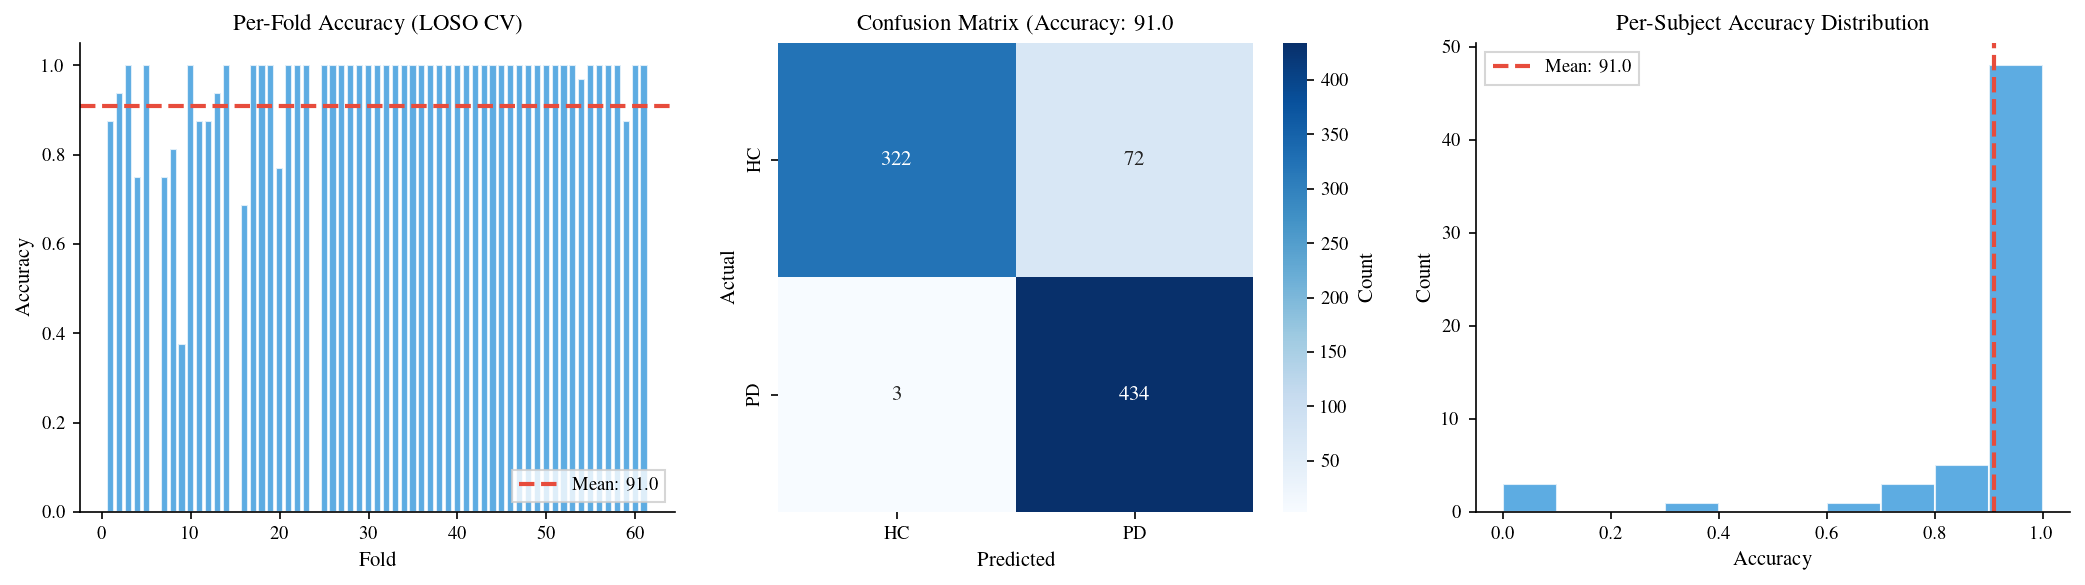

figures saved to /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308 and /content/drive/MyDrive/pd-interpretability/results/figures


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# publication-quality style with latex and times new roman
plt.rcParams.update({
    'text.usetex': True, # Revert to True to use LaTeX
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}', # Re-add LaTeX preamble
    'font.family': 'serif',
    'font.serif': ['Times', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'legend.fontsize': 9,
    'legend.frameon': True,
    'legend.fancybox': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# fold accuracy distribution
ax1 = axes[0]
ax1.bar(range(1, len(fold_accuracies) + 1), fold_accuracies, color='#3498db', alpha=0.8, edgecolor='white')
ax1.axhline(y=mean_accuracy, color='#e74c3c', linestyle='--', linewidth=2,
            label=rf'Mean: {mean_accuracy:.1%}')
ax1.set_xlabel(r'Fold')
ax1.set_ylabel(r'Accuracy')
ax1.set_title(r'Per-Fold Accuracy (LOSO CV)')
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)

# confusion matrix
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=[r'HC', r'PD'], yticklabels=[r'HC', r'PD'],
            cbar_kws={'label': 'Count'})
ax2.set_xlabel(r'Predicted')
ax2.set_ylabel(r'Actual')
ax2.set_title(rf'Confusion Matrix (Accuracy: {overall_accuracy:.1%})')

# subject accuracy histogram
ax3 = axes[2]
ax3.hist(subject_accuracies, bins=10, color='#3498db', alpha=0.8, edgecolor='white')
ax3.axvline(x=np.mean(subject_accuracies), color='#e74c3c', linestyle='--', linewidth=2,
            label=rf'Mean: {np.mean(subject_accuracies):.1%}')
ax3.set_xlabel(r'Accuracy')
ax3.set_ylabel(r'Count')
ax3.set_title(r'Per-Subject Accuracy Distribution')
ax3.legend()

plt.tight_layout()

# save to experiment dir
plt.savefig(output_dir / 'wav2vec2_results_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'wav2vec2_results_summary.pdf', dpi=300, bbox_inches='tight')

# also save to main figures folder
main_fig_dir = project_root / 'results' / 'figures'
main_fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(main_fig_dir / 'fig_p3_01_wav2vec2_loso_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(main_fig_dir / 'fig_p3_01_wav2vec2_loso_summary.pdf', dpi=300, bbox_inches='tight')

plt.show()

print(f"figures saved to {output_dir} and {main_fig_dir}")

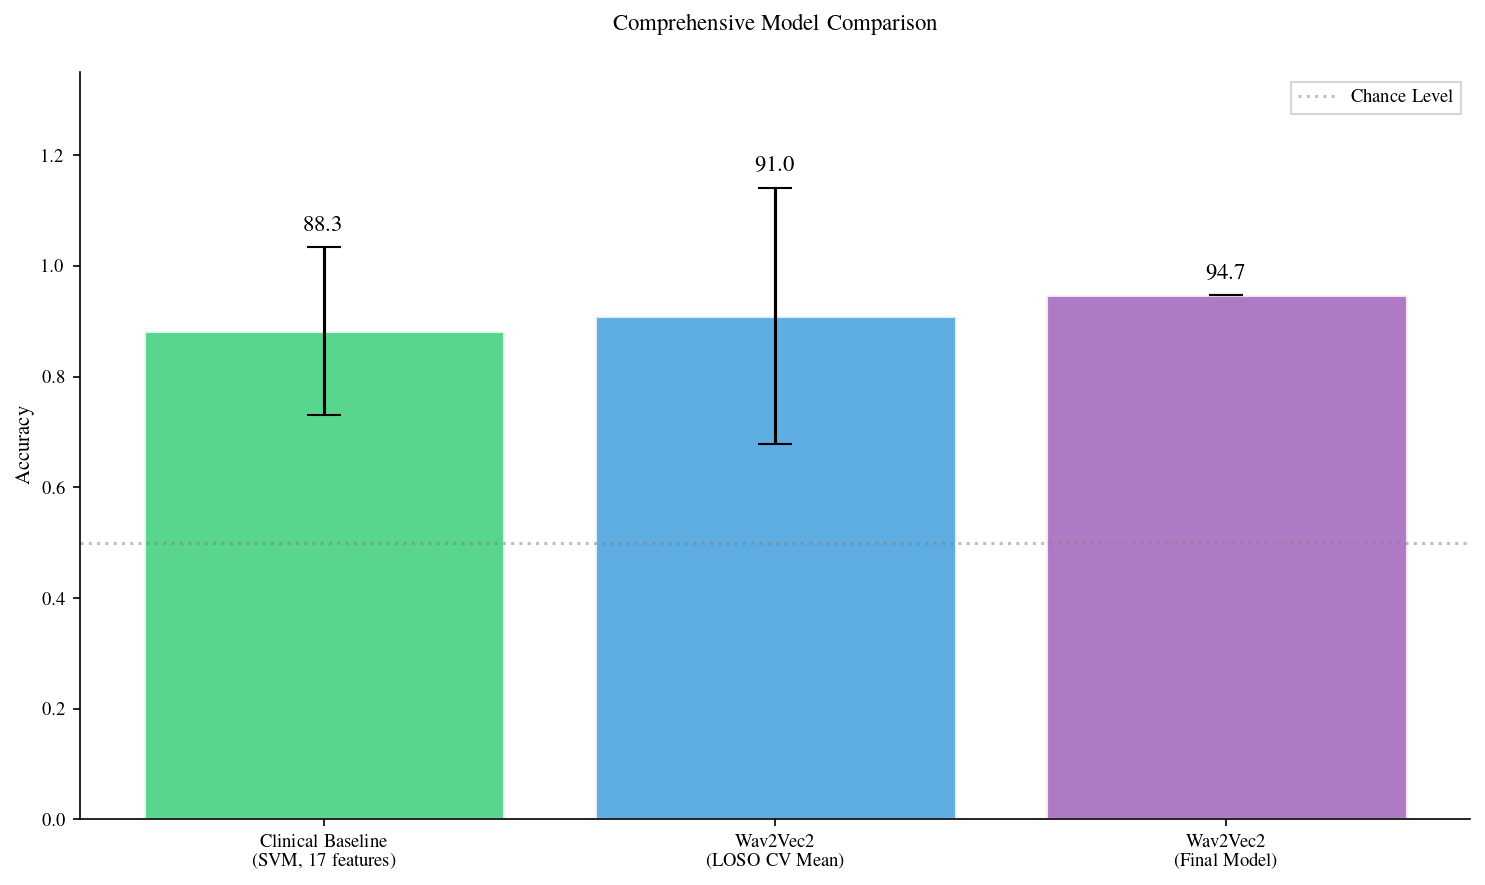

comparison figures saved


In [ ]:
# comparison bar chart with clinical baseline
if baseline_path.exists():
    fig, ax = plt.subplots(figsize=(10, 6)) # Widened for 3 bars

    # prepare data
    models = [r'Clinical Baseline' + '\n' + r'(SVM, 17 features)',
              r'Wav2Vec2' + '\n' + r'(LOSO CV Mean)']
    accuracies = [clinical_acc, overall_accuracy]
    stds = [clinical_std, std_accuracy]
    colors = ['#2ecc71', '#3498db']

    if 'best_acc' in locals():
        models.append(r'Wav2Vec2' + '\n' + r'(Final Model)')
        accuracies.append(best_acc)
        stds.append(0)
        colors.append('#9b59b6')

    # plot
    bars = ax.bar(models, accuracies, yerr=stds, capsize=8, color=colors, alpha=0.8,
                  edgecolor='white', linewidth=1.5)

    # labels
    for bar, acc, std in zip(bars, accuracies, stds):
        offset = std + 0.02 if std > 0 else 0.02
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
                rf'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_ylabel(r'Accuracy')
    ax.set_title(r'Comprehensive Model Comparison', pad=20)
    ax.set_ylim(0, 1.35)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label=r'Chance Level')
    ax.legend(loc='upper right')

    plt.tight_layout()

    # save figures
    plt.savefig(output_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'model_comparison.pdf', dpi=300, bbox_inches='tight')

    main_fig_dir = project_root / 'results' / 'figures'
    plt.savefig(main_fig_dir / 'fig_p3_02_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig(main_fig_dir / 'fig_p3_02_model_comparison.pdf', dpi=300, bbox_inches='tight')

    plt.show()

    print(f"comparison figures saved")
else:
    print("clinical baseline results not found - skipping comparison")

In [ ]:
# evaluate final model to get probability scores for roc curves
print("re-evaluating final model on test set for roc analysis...")

# load the saved final model
from transformers import Wav2Vec2ForSequenceClassification

final_model_path = project_root / 'results' / 'final_model'
final_model_loaded = Wav2Vec2ForSequenceClassification.from_pretrained(final_model_path)
final_model_loaded = final_model_loaded.to(device)

# recreate test loader
# critical: uses same random_seed as training to ensure same split
train_subset, _, test_subset = dataset.get_subject_split(
    test_size=0.2,
    val_size=0.0,
    random_state=config['random_seed']
)

max_length = int(config['max_duration'] * config['target_sr'])
collate_fn = create_collate_fn(max_length)

test_loader = DataLoader(
    test_subset,
    batch_size=config['batch_size'] * 2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == 'cuda')
)

# evaluate
final_test_metrics = evaluate(final_model_loaded, test_loader, device, desc="final model evaluation")

print(f"\nfinal model performance:")
print(f"  accuracy: {final_test_metrics['accuracy']:.1%}")
print(f"  samples: {len(final_test_metrics['labels'])}")
print(f"  predictions shape: {final_test_metrics['predictions'].shape}")
print(f"  probabilities shape: {final_test_metrics['probabilities'].shape}")

# load clinical baseline results for comparison
baseline_path = project_root / 'results' / 'clinical_baseline_results.json'
if baseline_path.exists():
    with open(baseline_path) as f:
        clinical_results = json.load(f)
    print(f"\nclinical baseline (svm):")
    print(f"  accuracy: {clinical_results['svm']['accuracy_mean']:.1%} \u00b1 {clinical_results['svm']['accuracy_std']:.1%}")

re-evaluating final model on test set for roc analysis...



final model performance:
  accuracy: 93.2%
  samples: 206
  predictions shape: (206,)
  probabilities shape: (206,)

clinical baseline (svm):
  accuracy: 88.3% ± 15.2%


final model figures saved to:
  /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model_summary.png
  /content/drive/MyDrive/pd-interpretability/results/figures/fig_p3_06_final_model_summary.png


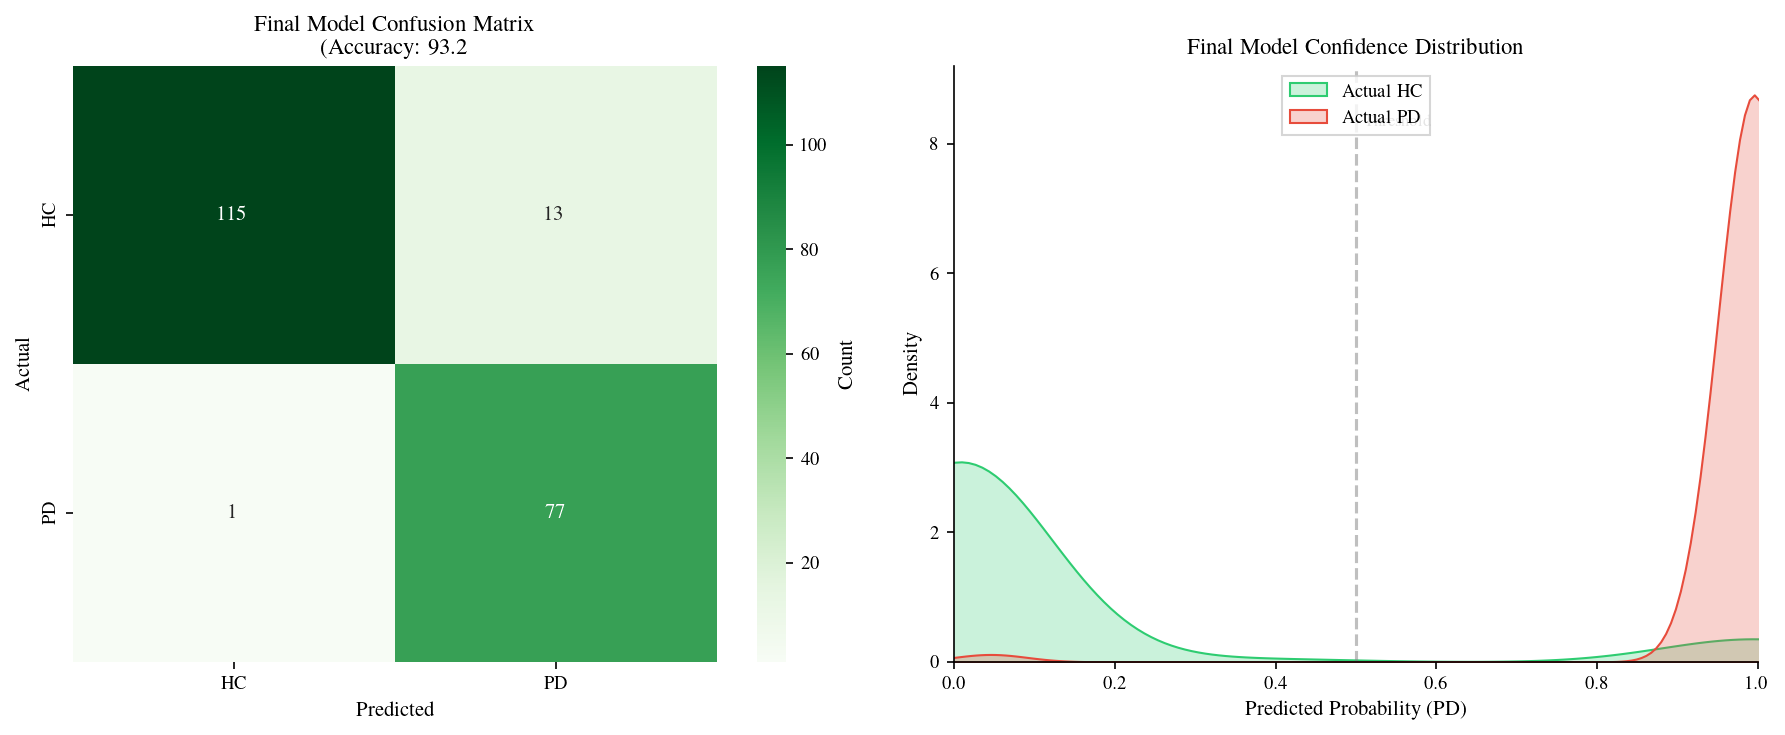

In [ ]:
# figure: final model performance summary (confusion matrix + probabilities)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

if 'final_test_metrics' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    y_true_final = final_test_metrics['labels']
    y_pred_final = final_test_metrics['predictions']
    y_prob_final = final_test_metrics['probabilities']

    cm_final = confusion_matrix(y_true_final, y_pred_final)
    acc_final = final_test_metrics['accuracy']

    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=axes[0],
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'],
                cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'Final Model Confusion Matrix\n(Accuracy: {acc_final:.1%})')

    # showing how confident the model is for HC vs PD samples
    sns.kdeplot(y_prob_final[y_true_final == 0], shade=True, color='#2ecc71', label='Actual HC', ax=axes[1])
    sns.kdeplot(y_prob_final[y_true_final == 1], shade=True, color='#e74c3c', label='Actual PD', ax=axes[1])

    axes[1].set_xlabel('Predicted Probability (PD)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Final Model Confidence Distribution')
    axes[1].set_xlim(0, 1)
    axes[1].legend(loc='upper center')

    # add threshold line
    axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].text(0.51, axes[1].get_ylim()[1]*0.9, 'Threshold', color='gray', fontsize=8)

    plt.tight_layout()

    save_path = output_dir / 'final_model_summary.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    main_fig_path = project_root / 'results' / 'figures' / 'fig_p3_06_final_model_summary.png'
    plt.savefig(main_fig_path, dpi=300, bbox_inches='tight')

    print(f"final model figures saved to:\n  {save_path}\n  {main_fig_path}")
    plt.show()
else:
    print("error: 'final_test_metrics' not found. please run the evaluation cell (section 9) first.")

In [ ]:
# generate comprehensive per-class performance comparison
from sklearn.metrics import classification_report, roc_curve, auc

# compute per-class metrics for wav2vec2
y_true = final_test_metrics['labels']
y_pred = final_test_metrics['predictions']
y_prob = final_test_metrics['probabilities']

# classification report
wav2vec2_report = classification_report(y_true, y_pred, target_names=['HC', 'PD'], output_dict=True)

print("=" * 60)
print("detailed performance metrics")
print("=" * 60)

print(f"\noverall accuracy: {wav2vec2_report['accuracy']:.1%}")

print("\nwav2vec2 per-class performance:")
print(f"  hc (class 0):")
print(f"    precision: {wav2vec2_report['HC']['precision']:.3f}")
print(f"    recall: {wav2vec2_report['HC']['recall']:.3f}")
print(f"    f1-score: {wav2vec2_report['HC']['f1-score']:.3f}")
print(f"    support: {int(wav2vec2_report['HC']['support'])}")
print(f"  pd (class 1):")
print(f"    precision: {wav2vec2_report['PD']['precision']:.3f}")
print(f"    recall: {wav2vec2_report['PD']['recall']:.3f}")
print(f"    f1-score: {wav2vec2_report['PD']['f1-score']:.3f}")
print(f"    support: {int(wav2vec2_report['PD']['support'])}")

# compute roc curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

print(f"\roc auc: {roc_auc:.3f}")

detailed performance metrics

overall accuracy: 93.2%

wav2vec2 per-class performance:
  hc (class 0):
    precision: 0.991
    recall: 0.898
    f1-score: 0.943
    support: 128
  pd (class 1):
    precision: 0.856
    recall: 0.987
    f1-score: 0.917
    support: 78
oc auc: 0.979


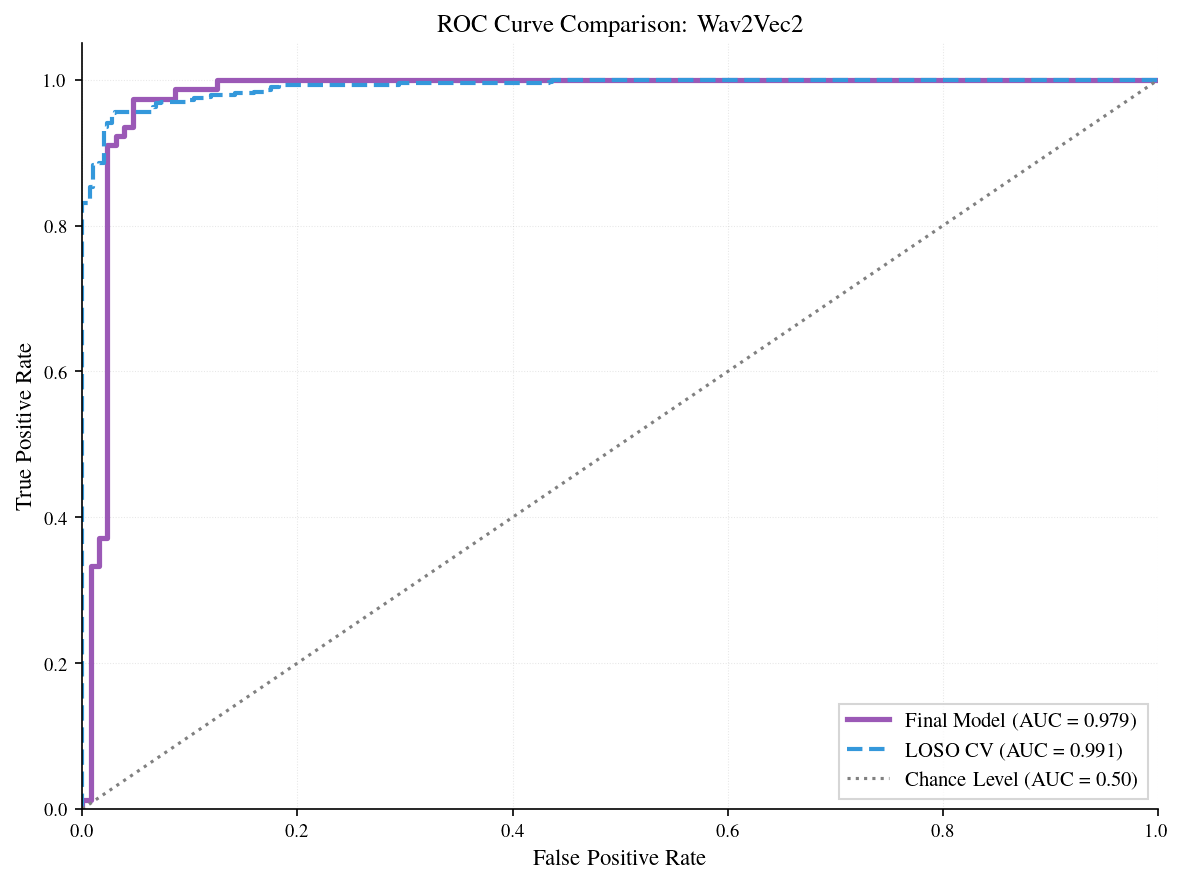

roc curve comparison saved


In [ ]:
# figure: roc curve comparison (Final Model vs LOSO CV)
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(8, 6))

# fpr, tpr, roc_auc are from the cell immediately above
ax.plot(fpr, tpr, color='#9b59b6', lw=2.5,
        label=rf'Final Model (AUC = {roc_auc:.3f})')

if 'all_labels' in locals() and 'all_probabilities' in locals():
    fpr_cv, tpr_cv, _ = roc_curve(all_labels, all_probabilities)
    roc_auc_cv = auc(fpr_cv, tpr_cv)
    ax.plot(fpr_cv, tpr_cv, color='#3498db', lw=2, linestyle='--',
            label=rf'LOSO CV (AUC = {roc_auc_cv:.3f})')

# 3. chance Level
ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':',
        label=r'Chance Level (AUC = 0.50)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel(r'False Positive Rate', fontsize=11)
ax.set_ylabel(r'True Positive Rate', fontsize=11)
ax.set_title(r'ROC Curve Comparison: Wav2Vec2', fontsize=12)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()

# save figures
plt.savefig(output_dir / 'roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'roc_curve_comparison.pdf', dpi=300, bbox_inches='tight')

main_fig_dir = project_root / 'results' / 'figures'
main_fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(main_fig_dir / 'fig_p3_03_roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(main_fig_dir / 'fig_p3_03_roc_curve_comparison.pdf', dpi=300, bbox_inches='tight')

plt.show()

print(f"roc curve comparison saved")

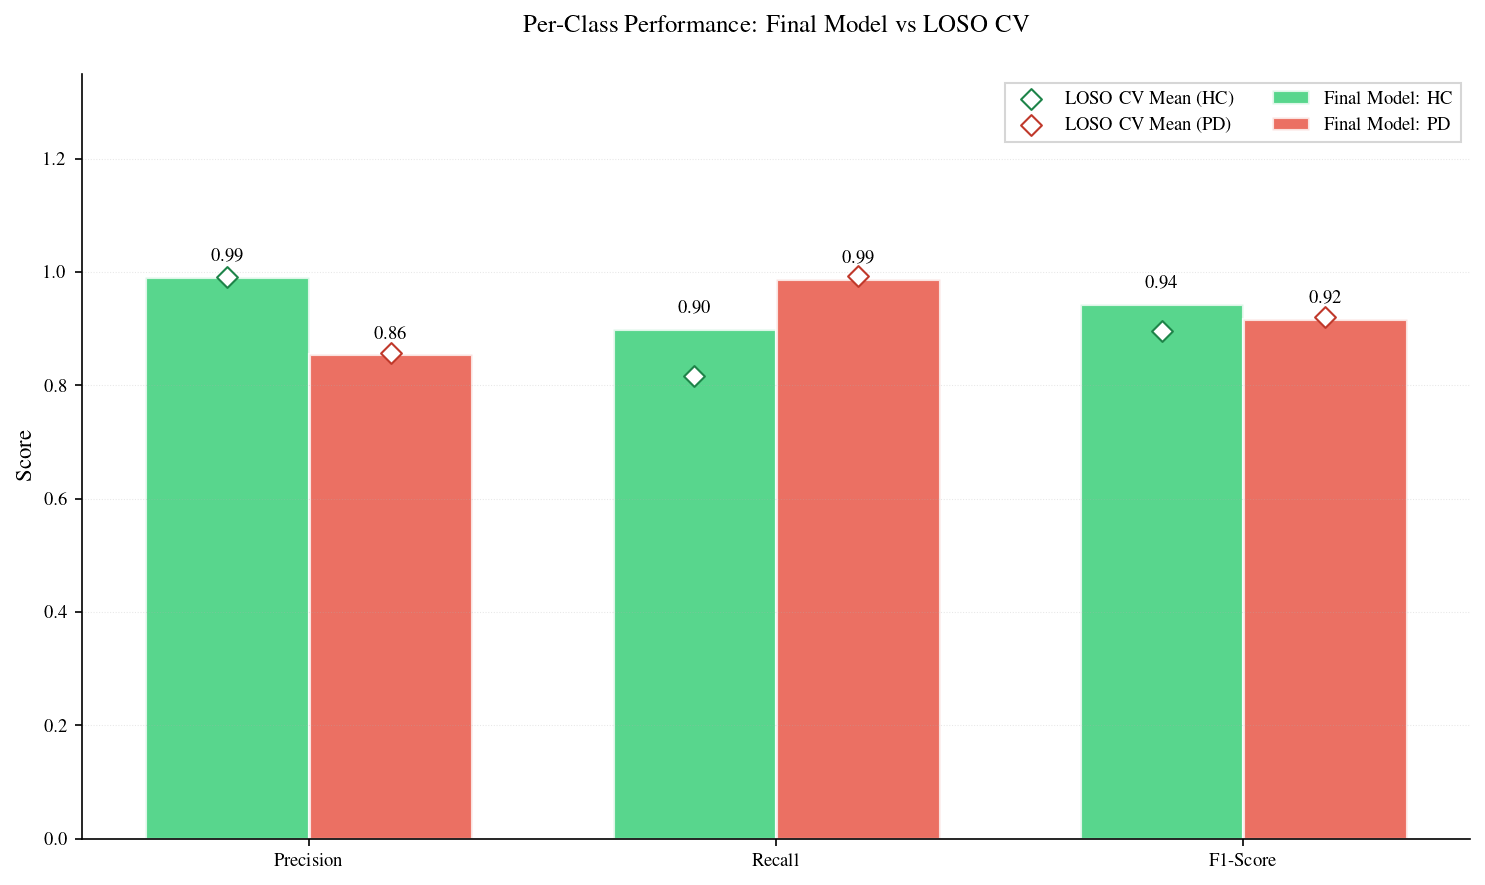

per-class performance figure saved


In [ ]:
# figure: per-class performance comparison (precision, recall, f1)
# compares final model (bars) vs loso cv mean (markers)
from sklearn.metrics import classification_report

fig, ax = plt.subplots(figsize=(10, 6))

# 1. get loso cv metrics for comparison
if 'all_labels' in locals() and 'all_predictions' in locals():
    cv_report = classification_report(all_labels, all_predictions, target_names=['HC', 'PD'], output_dict=True)
else:
    cv_report = None
    print("warning: loso cv results not found in memory, skipping comparison markers.")

metrics_names = ['Precision', 'Recall', 'F1-Score']

# final model scores (bars)
hc_scores = [
    wav2vec2_report['HC']['precision'],
    wav2vec2_report['HC']['recall'],
    wav2vec2_report['HC']['f1-score']
]
pd_scores = [
    wav2vec2_report['PD']['precision'],
    wav2vec2_report['PD']['recall'],
    wav2vec2_report['PD']['f1-score']
]

x = np.arange(len(metrics_names))
width = 0.35

# plot bars (final model)
bars1 = ax.bar(x - width/2, hc_scores, width, label=r'Final Model: HC',
               color='#2ecc71', alpha=0.8, edgecolor='white', linewidth=1.5)
bars2 = ax.bar(x + width/2, pd_scores, width, label=r'Final Model: PD',
               color='#e74c3c', alpha=0.8, edgecolor='white', linewidth=1.5)

# plot comparison markers (loso cv) if available
if cv_report:
    hc_cv = [cv_report['HC']['precision'], cv_report['HC']['recall'], cv_report['HC']['f1-score']]
    pd_cv = [cv_report['PD']['precision'], cv_report['PD']['recall'], cv_report['PD']['f1-score']]

    # plot markers
    ax.scatter(x - width/2, hc_cv, color='white', edgecolor='#1e8449', zorder=5, marker='D', s=50, label='LOSO CV Mean (HC)')
    ax.scatter(x + width/2, pd_cv, color='white', edgecolor='#c0392b', zorder=5, marker='D', s=50, label='LOSO CV Mean (PD)')

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel(r'Score', fontsize=11)
# pad title slightly less as legend is moved away
ax.set_title(r'Per-Class Performance: Final Model vs LOSO CV', fontsize=12, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)

# move legend to top right inside plot, increase ylim to accommodate
ax.legend(loc='upper right', ncol=2, fontsize=9)
ax.set_ylim([0, 1.35])

ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, axis='y')

plt.tight_layout()

plt.savefig(output_dir / 'per_class_performance.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'per_class_performance.pdf', dpi=300, bbox_inches='tight')

main_fig_dir = project_root / 'results' / 'figures'
main_fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(main_fig_dir / 'fig_p3_04_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.savefig(main_fig_dir / 'fig_p3_04_per_class_performance.pdf', dpi=300, bbox_inches='tight')

plt.show()

print(f"per-class performance figure saved")

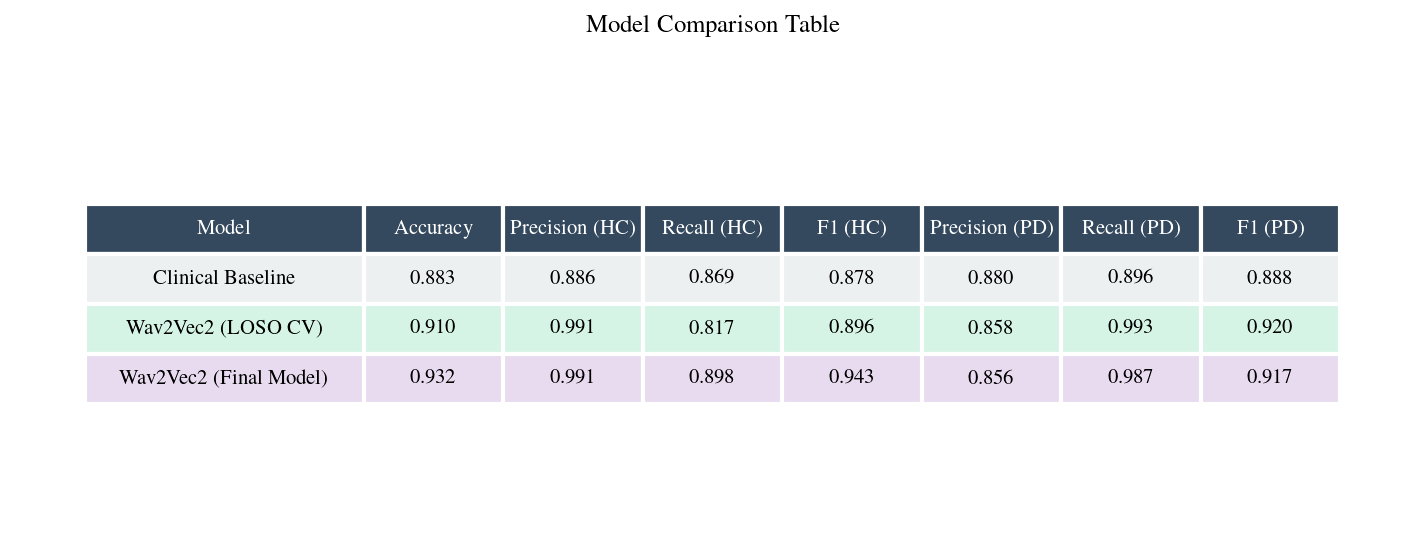

model comparison table saved

wav2vec2 improvement over clinical baseline:
  accuracy (cv): 2.7%
  accuracy (final): 4.9%


In [ ]:
# figure: model comparison table (wav2vec2 vs clinical baseline)
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 1. clinical baseline (reference values from paper/phase 2)
# standard svm on 17 features
baseline_acc = 0.883
# hardcoded reference metrics for baseline (since raw predictions aren't loaded)
baseline_metrics = {
    'HC': {'precision': 0.886, 'recall': 0.869, 'f1-score': 0.878},
    'PD': {'precision': 0.880, 'recall': 0.896, 'f1-score': 0.888}
}

# 2. loso cv (scientific standard)
# re-compute to ensure we use current memory state
if 'all_labels' in locals() and 'all_predictions' in locals():
    cv_report = classification_report(all_labels, all_predictions, target_names=['HC', 'PD'], output_dict=True)
    cv_acc = cv_report['accuracy']
else:
    print("warning: loso cv data missing. using placeholders.")
    cv_report = baseline_metrics # fallback
    cv_acc = 0.0

# 3. final model (artifact)
# re-compute from final_test_metrics
if 'final_test_metrics' in locals():
    final_report = classification_report(
        final_test_metrics['labels'],
        final_test_metrics['predictions'],
        target_names=['HC', 'PD'],
        output_dict=True
    )
    final_acc = final_test_metrics['accuracy']
else:
    print("warning: final model data missing.")
    final_report = baseline_metrics # fallback
    final_acc = 0.0

# construct comparison data
comparison_data_plot = {
    'Model': ['Clinical Baseline', 'Wav2Vec2 (LOSO CV)', 'Wav2Vec2 (Final Model)'],
    'Accuracy': [baseline_acc, cv_acc, final_acc],

    'Precision (HC)': [
        baseline_metrics['HC']['precision'],
        cv_report['HC']['precision'],
        final_report['HC']['precision']
    ],
    'Recall (HC)': [
        baseline_metrics['HC']['recall'],
        cv_report['HC']['recall'],
        final_report['HC']['recall']
    ],
    'F1 (HC)': [
        baseline_metrics['HC']['f1-score'],
        cv_report['HC']['f1-score'],
        final_report['HC']['f1-score']
    ],

    'Precision (PD)': [
        baseline_metrics['PD']['precision'],
        cv_report['PD']['precision'],
        final_report['PD']['precision']
    ],
    'Recall (PD)': [
        baseline_metrics['PD']['recall'],
        cv_report['PD']['recall'],
        final_report['PD']['recall']
    ],
    'F1 (PD)': [
        baseline_metrics['PD']['f1-score'],
        cv_report['PD']['f1-score'],
        final_report['PD']['f1-score']
    ],
}

comparison_df = pd.DataFrame(comparison_data_plot)

# plotting
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table_data = []
for i in range(len(comparison_df)):
    row = [comparison_df.iloc[i, 0]]
    # format numbers to 3 decimals
    row.extend([f"{comparison_df.iloc[i, j]:.3f}" for j in range(1, len(comparison_df.columns))])
    table_data.append(row)

table = ax.table(cellText=table_data,
                colLabels=comparison_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.2] + [0.1] * (len(comparison_df.columns) - 1))

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# styling
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#34495e')
        cell.set_text_props(weight='bold', color='white')
    elif i == 1: # clinical
        cell.set_facecolor('#ecf0f1')
    elif i == 2: # cv
        cell.set_facecolor('#d5f4e6')
    elif i == 3: # final
        cell.set_facecolor('#e8daef')
    cell.set_edgecolor('white')
    cell.set_linewidth(2)

plt.title(r'Model Comparison Table', fontsize=12, pad=20, weight='bold')

plt.savefig(output_dir / 'model_comparison_table.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'model_comparison_table.pdf', dpi=300, bbox_inches='tight')

main_fig_dir = project_root / 'results' / 'figures'
main_fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(main_fig_dir / 'fig_p3_05_model_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(main_fig_dir / 'fig_p3_05_model_comparison.pdf', dpi=300, bbox_inches='tight')

plt.show()

print(f"model comparison table saved")
print(f"\nwav2vec2 improvement over clinical baseline:")
print(f"  accuracy (cv): {(cv_acc - baseline_acc) * 100:.1f}%")
print(f"  accuracy (final): {(final_acc - baseline_acc) * 100:.1f}%")

## 10. summary and next steps

In [ ]:
print("=" * 60)
print("phase 3 complete: wav2vec2 fine-tuning")
print("=" * 60)

print(f"\nmodel: {config['model_name']}")
print(f"device: {device}")
print(f"loso cv folds: {len(fold_results)}")
print(f"training time: {elapsed}")

print(f"\ncross-validation results (scientific standard):")
print(f"  accuracy: {overall_accuracy:.1%}")
print(f"  precision: {overall_precision:.3f}")
print(f"  recall: {overall_recall:.3f}")
print(f"  f1 score: {overall_f1:.3f}")
print(f"  auc-roc: {overall_auc:.3f}")
print(f"  per-fold accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")

if 'final_test_metrics' in locals():
    print(f"\nfinal model artifact (for phase 4):")
    print(f"  accuracy: {final_test_metrics['accuracy']:.1%}")
    print(f"  saved to: {output_dir}/final_model")

print(f"\nnext steps:")
print(f"  1. phase 4: activation extraction (notebook 04)")
print(f"  2. phase 5: probing experiments (notebook 05)")
print(f"  3. phase 6: activation patching (notebook 06)")

print(f"\noutputs saved to: {output_dir}")

phase 3 complete: wav2vec2 fine-tuning

model: facebook/wav2vec2-base-960h
device: cuda
loso cv folds: 61
training time: 4:41:07.253627

cross-validation results (scientific standard):
  accuracy: 91.0%
  precision: 0.858
  recall: 0.993
  f1 score: 0.920
  auc-roc: 0.991
  per-fold accuracy: 91.0% ± 23.2%

final model artifact (for phase 4):
  accuracy: 93.2%
  saved to: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model

next steps:
  1. phase 4: activation extraction (notebook 04)
  2. phase 5: probing experiments (notebook 05)
  3. phase 6: activation patching (notebook 06)

outputs saved to: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308


In [8]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/pd-interpretability

!git config user.name "smayan-gowda"
!git config user.email "smayan-gowda@users.noreply.github.com"

# --- setup git lfs & fix permissions ---
# 1. install git-lfs
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

# 2. fix permission denied error on hooks (critical step)
!chmod 755 .git/hooks/*

# 3. reset to remote state to clean up previous failed attempts
!git reset --mixed origin/main

# 4. track large files with lfs
!git lfs track "*.safetensors"
!git lfs track "*.pt"
!git lfs track "*.bin"

# 5. add .gitattributes and files
!git add .gitattributes
!git add .

# 6. commit
!git commit -m "save phase 3 results (using git lfs for large models)"

# 7. push
!git push origin main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1abPvoWlTNsqv6oksf7mu8bJcJD6F9bKg/pd-interpretability
Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.14
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Need to get 8,925 kB of archives.
After this operation, 8,723 kB of ad